# 0.0. IMPORTS

In [265]:
# O comando abaixo configura a exibição das celulas e valores para utilizar 100% da largura da tela. 
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [266]:
import math
import pandas as pd
import inflection
import numpy as np
from numpy import int64
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib import gridspec
from IPython.display import Image
import datetime
import warnings

## 0.1. Helper Funcions

## 0.2 Loading Data

In [267]:
# low memory = False significa que vai carregar todo o arquivo em memória. Caso tenho restrição com memória,
# low_memory=True carrega chunks do arquivo na memória.
df_sales_raw = pd.read_csv('data/train.csv', low_memory=False)
df_store_raw = pd.read_csv('data/store.csv', low_memory=False)

# Realiza o merge dos dois datasets df_sales_raw e df_store_raw. O atributo on='Store' define que a coluna Store é 
# a coluna que aparece em ambos os datasets e será utilizado como chave para fazer o merge.
df_raw = pd.merge(df_sales_raw, df_store_raw, how='left', on='Store')

In [268]:
# O comando sample exibe uma linha aleatória do dataset.
df_raw.sample()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
703095,316,3,2013-10-09,10989,904,1,1,0,0,d,a,9000.0,8.0,2001.0,0,NaN,NaN,NaN


# 1.0. PASSO 01 - DESCRIÇÃO DOS DADOS

In [269]:
# É recomendado realizar uma cópia do dataset em cada um das seçoes do Jupyter Notebook, pois se o notebook tem muitas seções
# e em um exemplo onde estamos na última seção e reescrevemos os dados originais e ocorre um erro. Neste caso para recuperarmos
# os dados originais, temos que voltar na primeira seção do Jupyter Notebook e executar todas as linhas até o final.
# Para evitar este problema é recomendado criar uma cópia do dataset em cada seção.
df1 = df_raw.copy()

## 1.1 Rename Columns

In [270]:
# Exibe as colunas do dataset df1, no formato original CamelCase.
df1.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

In [271]:
# Cria uma lista com os nomes originais das colunas.
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday', 'StoreType',
            'Assortment', 'CompetitionDistance', 'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2',
            'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval']

# Altera o estilo dos nomes das colunas de CamelCase para SnakeCase utilizando a função abaixo.
snakecase = lambda x: inflection.underscore(x)

# A função map executa a função snakecase em todas as palavras da lista cols_old. A saída desta função é convertida em uma 
# lista e armazenada na lista cols_new.
cols_new = list(map(snakecase, cols_old))

# Renomeia o nome das colunas no dataset df1.
df1.columns = cols_new

In [272]:
# Exibe o nome das colunas do dataset df1 no formato alterado snakecase.
df1.columns

Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'promo_interval'],
      dtype='object')

## 1.2 Data Dimensions

In [273]:
print('Number of rows: {}'.format(df1.shape[0]))
print('Number of columns: {}'.format(df1.shape[1]))

Number of rows: 1017209
Number of columns: 18


## 1.3 Data Types

In [274]:
df1.dtypes

store                             int64
day_of_week                       int64
date                             object
sales                             int64
customers                         int64
open                              int64
promo                             int64
state_holiday                    object
school_holiday                    int64
store_type                       object
assortment                       object
competition_distance            float64
competition_open_since_month    float64
competition_open_since_year     float64
promo2                            int64
promo2_since_week               float64
promo2_since_year               float64
promo_interval                   object
dtype: object

In [275]:
# Altera o tipo dos valore da coluna date de object (string) para data.
df1['date'] = pd.to_datetime(df1['date'])

In [276]:
df1.dtypes 

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4 Check NA

In [277]:
# O método isna exibe todas as linhas que possuem valores vazios. O método sum exibe a quantidade de linhas que possuem 
# valores vazios / NA(não aplicável).
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5 Fillout NA

### 1.5.1. competition_distance

In [278]:
# competition_distance
# No site do Kagle temos a seguinte definição para esta coluna: distance in meter to the nearest competitor store.
# Iremos verificar no dataset qual é a distância em metros do competidor mais distante.
print(df1['competition_distance'].max())

75860.0


In [279]:
# O valor em metros do competidor mais distante é 75860.
# Então iremos assumir para os valores NA, um valor muito mais distante do que o competidor mais distante no nosso dataset.
# Neste caso, iremos considerar um valor de 200000 para os valores NA/vazio.

# O método math.isnan retorna se um valor em uma coluna específica é NA/vazio.
# No exemplo abaixo, temos uma condição onde se o valor da coluna competition_distance for vazio, substitui pelo valor 200000.0.
# 200000.0 if math.isnan (df1['competition_distance']) else df1['competition_distance']

# Para aplicarmos esta condição em todo o dataset, temos que utilizar as funções apply e lambda, conforme exemplo abaixo:
df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000.0 if math.isnan(x) else x)

In [280]:
# Verificamos agora que o maximo valor da columa competition_distance é 200000.0 e não existe mais valores vazios:
print(df1['competition_distance'].max())
df1.isna().sum()

200000.0


store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance                 0
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

### 1.5.2. competition_open_since_month

In [281]:
# competition_open_since_month
# No site do Kagle temos a seguinte definição para esta coluna: gives the approximate year and month of the time the nearest
# competitor was opened.
# O valor pode estar vazio porque não possui competidor, ou porque não sabemos a data de abertura do concorrente (pode ter
# sido aberta antes da inauguração da nossa loja, ou abriu depois mas alguém esqueceu de anotar.)
# Iremos então assumir como premissa, o valor do mês da coluna date. Iremos fazer isto pensando na etapa de feature engineering.
# Por exemplo, quanto tempo faz que um evento ocorreu? Iremos manter este valor na coluna, pois um competidor influencia no 
# volume de vendas. Quando um competidor abre recentemente, o volume de vendas na nossa loja cai. Com o tempo, as vendas 
# no nossa loja aumentam, porém não vão retornar ao patamar antes da inauguração do competidor.
# Assumir o valor do mês do campo date pode não ter lógica, pois temos a influência do campo competition_distance.
# Não sabemos se esta premissa vai funcionar, por isso, utilizamos o CRISP. Na primeira iteração do CRISP, iremos utilizar
# esta premissa. Se o algoritmos não performar bem, no próximo ciclo do CRISP, talvez podemos alterar esta premisa para
# esta coluna.

# O método math.isnan retorna se um valor em uma coluna específica é NA/vazio.
# No exemplo abaixo, temos uma condição onde se o valor da coluna competition_open_since_month for vazio, substitui pelo valor
# da coluna data.
# df1['date'].month if math.isnan (df1['competition_open_since_month']) else df1['competition_open_since_month']

# Para aplicarmos esta condição em todo o dataset, temos que utilizar as funções apply e lambda, conforme exemplo abaixo:

In [282]:
# Quando utilizamos mais de uma coluna, temos que especificar para a função apply que iremos aplicar os valores ao longo das
# colunas, utilizando o atributo axis=1.
df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis = 1)

### 1.5.3. competition_open_since_year

In [283]:
# competition_open_since_year
# No site do Kagle temos a seguinte definição para esta coluna: gives the approximate year and month of the time the nearest
# competitor was opened.
# O valor pode estar vazio porque não possui competidor, ou porque não sabemos a data de abertura do concorrente (pode ter
# sido aberta antes da inauguração da nossa loja, ou abriu depois mas alguém esqueceu de anotar.)
# Iremos então assumir como premissa, o valor do ano da coluna date. Iremos fazer isto pensando na etapa de feature engineering.
# Por exemplo, quanto tempo faz que um evento ocorreu? Iremos manter este valor na coluna, pois um competidor influencia no 
# volume de vendas. Quando um competidor abre recentemente, o volume de vendas na nossa loja cai. Com o tempo, as vendasB
# no nossa loja aumentam, porém não vão retornar ao patamar antes da inauguração do competidor.
# Assumir o valor do ano do campo date pode não ter lógica, pois temos a influência do campo competition_distance.
# Não sabemos se esta premissa vai funcionar, por isso, utilizamos o CRISP. Na primeira iteração do CRISP, iremos utilizar
# esta premissa. Se o algoritmos não performar bem, no próximo ciclo do CRISP, talvez podemos alterar esta premisa para
# esta coluna.

# O método math.isnan retorna se um valor em uma coluna específica é NA/vazio.
# No exemplo abaixo, temos uma condição onde se o valor da coluna competition_open_since_year for vazio, substitui pelo valor
# da coluna data.
# df1['date'].year if math.isnan (df1['competition_open_since_year']) else df1['competition_open_since_year']

# Para aplicarmos esta condição em todo o dataset, temos que utilizar as funções apply e lambda, conforme exemplo abaixo:

In [284]:
# Quando utilizamos mais de uma coluna, temos que especificar para a função apply que iremos aplicar os valores ao longo das
# colunas, utilizando o atributo axis=1.
df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis = 1)

### 1.5.4. promo2_since_week

In [285]:
# promo2_since_week.
# # No site do Kagle temos a seguinte definição para esta coluna: describes the year and calendar week when the store started
# participating in Promo2.
# Iremos substituir os valores faltantes pelo valor de week da coluna date.

# O método math.isnan retorna se um valor em uma coluna específica é NA/vazio.
# No exemplo abaixo, temos uma condição onde se o valor da coluna promo2_since_week for vazio, substitui pelo valor da coluna
# data.
# df1['date'].week if math.isnan (df1['promo2_since_week']) else df1['promo2_since_week']

# Para aplicarmos esta condição em todo o dataset, temos que utilizar as funções apply e lambda, conforme exemplo abaixo:

In [286]:
# Quando utilizamos mais de uma coluna, temos que especificar para a função apply que iremos aplicar os valores ao longo das
# colunas, utilizando o atributo axis=1.
df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis = 1)

### 1.5.5. promo2_since_year

In [287]:
# promo2_since_year.
# # No site do Kagle temos a seguinte definição para esta coluna: describes the year and calendar week when the store started
# participating in Promo2.
# Iremos substituir os valores faltantes pelo valor de year da coluna date.

# O método math.isnan retorna se um valor em uma coluna específica é NA/vazio.
# No exemplo abaixo, temos uma condição onde se o valor da coluna promo2_since_year for vazio, substitui pelo valor da coluna
# data.
# df1['date'].year if math.isnan (df1['promo2_since_year']) else df1['promo2_since_year']

# Para aplicarmos esta condição em todo o dataset, temos que utilizar as funções apply e lambda, conforme exemplo abaixo:

In [288]:
# Quando utilizamos mais de uma coluna, temos que especificar para a função apply que iremos aplicar os valores ao longo das
# colunas, utilizando o atributo axis=1.
df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis = 1)

### 1.5.6. promo_interval

In [289]:
# promo_interval.
# # No site do Kagle temos a seguinte definição para esta coluna: describes the consecutive intervals Promo2 is started,
# naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August,
# November of any given year for that store.

# Será criada uma coluna is_promo atribuindo o valor 0 quando a loja não participou da promoção. Caso contrário será atribuído
# o valor 1.

In [290]:
#Cria uma dicionário com os valores e nomes dos meses.
month_map = {1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun', 7:'Jul', 8:'Aug', 9:'Sept', 10:'Oct', 11:'Nov', 12:'Dec'}

In [291]:
# Se o valor da coluna promo_interval for NA/vazio, atribui o valor 0.
df1['promo_interval'].fillna(0, inplace=True) # inplace=True não exibe o resultado na tela.

In [292]:
# O comando abaixo cria uma coluna month_map, onde iremos abribuir o valor do mês do dicionário month_map de acordo com o 
# valor do mês que se encontra na coluna date.
df1['month_map'] = df1['date'].dt.month.map(month_map)

In [293]:
# Podemos realizar a mesma operação utilizando o comando abaixo:
# df1['month_map'] = df1['date'].dt.month.apply(lambda x: calendar.month_abbr[x])
# Porém, o tempo de execução é bem maior do que o comando: df1['month_map'] = df1['date'].dt.month.map(month_map).

In [294]:
# O comando abaixo exibe 5 amostras de linhas, onde cada amostra é exibida em uma coluna.
df1.sample(5).T

,392112,891807,268708,577204,110095
store,624,593,647,420,826
day_of_week,5,2,4,4,5
date,2014-07-18 00:00:00,2013-04-23 00:00:00,2014-11-27 00:00:00,2014-01-30 00:00:00,2015-04-24 00:00:00
sales,6669,9301,7566,3697,7352
customers,689,1225,747,350,696
open,1,1,1,1,1
promo,1,1,1,0,0
state_holiday,0,0,0,0,0
school_holiday,1,0,0,0,0
store_type,a,a,a,d,a


In [295]:
# É criada uma coluna chamada is_promo.
# É criada a seguinte condição: se o valor da coluna promo_interval for igual à 0, será atribuído o valor 0 na coluna is_promo,
# significando que ela não está participando da promoção.
# Se o valor da coluna promo_interval for diferente de zero, iremos atribuir o valor 1 na coluna is_promo, se algum dos meses
# contidos no valor da coluna promo_interval for igual ao valor do mês na coluna month_map. Caso contrário, será atribuído
# o valor 0 na coluna is_promo.
# É utilizada a função split para criar uma lista com os valores contidos na coluna promo_interval, considerando que os valores
# são separados por vírgula.
# 0 if df1['promo_interval'] == 0 else 1 if df1['month_map'] in df1['promo_interval'].split(',') else 0

# Para aplicarmos esta condição em todo o dataset, temos que utilizar as funções apply e lambda, conforme exemplo abaixo:
df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis=1)

In [296]:
# O comando abaixo verifica uma determinada condição. Fiz este comando porque havia escrito 'Sep' em vez de 'Sept' na list
# month_map o que estava causando uma diferença nos valores do descriptive statistical.
# O comando abaixo cria um dataset df_teste que contem o valor Sept na coluna month_map e que contém a string 'Sept' no valor
# da coluna promo_interval.
df_teste = df1[(df1['month_map'] == 'Sept') & (df1['promo_interval'].str.contains('Sept'))]
df_teste.sample(5).T

,712882,329541,336393,733717,715262
store,68,721,1077,833,218
day_of_week,1,2,2,4,6
date,2013-09-30 00:00:00,2014-09-23 00:00:00,2014-09-16 00:00:00,2013-09-12 00:00:00,2013-09-28 00:00:00
sales,6878,5796,4619,5401,2715
customers,1087,685,496,501,381
open,1,1,1,1,1
promo,0,0,1,1,0
state_holiday,0,0,0,0,0
school_holiday,0,0,0,0,0
store_type,a,a,a,d,a


In [297]:
# O comando abaixo exibe 5 amostras de linhas, onde cada amostra é exibida em uma coluna.
df1.sample(5).T

,672438,31031,1009065,211071,899343
store,879,927,776,337,324
day_of_week,3,6,2,5,2
date,2013-11-06 00:00:00,2015-07-04 00:00:00,2013-01-08 00:00:00,2015-01-23 00:00:00,2013-04-16 00:00:00
sales,3726,3812,6932,5385,5208
customers,326,514,704,410,789
open,1,1,1,1,1
promo,1,0,1,0,0
state_holiday,0,0,0,0,0
school_holiday,0,0,0,0,0
store_type,d,a,c,d,a


In [298]:
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

## 1.6 Change Type

In [299]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

In [300]:
# Altera os valores das colunas abaixo de float para int64.
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int64)
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int64)
df1['promo2_since_week'] = df1['promo2_since_week'].astype(int64)
df1['promo2_since_year'] = df1['promo2_since_year'].astype(int64)

In [301]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                        int64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

In [302]:
df1.sample(5).T

,34333,628523,545834,232454,958155
store,884,449,270,535,41
day_of_week,3,7,4,7,5
date,2015-07-01 00:00:00,2013-12-15 00:00:00,2014-02-27 00:00:00,2015-01-04 00:00:00,2013-02-22 00:00:00
sales,6531,0,7432,0,4571
customers,560,0,1052,0,354
open,1,0,1,0,1
promo,1,0,0,0,1
state_holiday,0,0,0,0,0
school_holiday,0,0,0,0,0
store_type,d,a,a,a,d


## 1.7 Descriptive Statistical

In [303]:
# Primeiro devemos separar os dados númericos dos dados categóricos em diferentes dataset.
# No exemplo abaixo, foi criado um dataset num_attributes para armazenar os valores numéricos e um dataset chamado
# cat_attributes para armazenar os valores categóricos (exclui números inteiros, float e data).
num_attributes = df1.select_dtypes(include=['int64', 'float64'])
cat_attributes = df1.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])

### 1.7.1 Numerical Attributes

In [304]:
# Central Tendency - mean, median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T  # Calcula a média.
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T  # Calcula a mediana.

# Dispersion - std, min, max, range(max-min), skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(np.min)).T
d3 = pd.DataFrame(num_attributes.apply(np.max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

# Concatenate
# Concate os dataframes em um único dataframe chamado m.
m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6 ]).T.reset_index()

# Renomeia as colunas
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']

# O VALOR DE IS_PROMO ESTÁ DIFERENTE DOS VALORES MOSTRADOS NO TREINAMENTO.

In [305]:
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


In [306]:
# skew: é uma medidade de quanto assimetrico está uma distribuição.
# https://medium.com/@atanudan/kurtosis-skew-function-in-pandas-aa63d72e20de
# Em uma distribuição normal, a média divide a curva simetricamente em duas partes iguais na mediana e o valor da assimetria
# é zero.
# Quando uma distribuição é assimétrica, a cauda da distribuição é inclinada para um lado para a direita ou para a esquerda.
# Quando o valor da assimetria é negativo, a cauda da distribuição é mais longa para o lado esquerdo da curva.
# Quando o valor da assimetria é positivo, a cauda da distribuição é mais longa para o lado direito da curva.

# Se a assimetria estiver entre -0,5 e 0,5, os dados são bastante simétricos.
# Se a assimetria estiver entre -1 e - 0,5 ou entre 0,5 e 1, os dados estão moderadamente inclinados.
# Se a assimetria for menor que -1 ou maior que 1, os dados estão altamente inclinados.

# O exemplo abaixo exibe a distribuição da coluna competition_distance, onde podemos observar a cauda da distribuição para
# o lado direito, correspondendo ao valor do skew positivo próximo de 10.

<AxesSubplot:xlabel='competition_distance', ylabel='Density'>

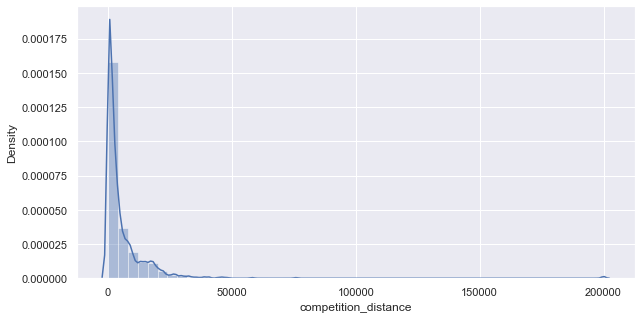

In [307]:
# A função distplot do seaborn exibe a distribuição dos dados.
sns.distplot(df1['competition_distance'])

In [308]:
# kurtosis: é uma das duas medidas que quantificam a forma de uma distribuição.
# kurtosis determina o volume de outliers, descrevendo o pico da distribuição.

# Se a distribuição for alta e fina, é chamada de distribuição leptocúrtica (kurtosis > 3). Os valores em uma distribuição
# leptocúrtica estão próximos da média ou nos extremos.
# Uma distribuição plana onde os valores são moderadamente espalhados (isto é, ao contrário da leptocúrtica) é chamada de 
# distribuição platicúrtica (kurtosis <3).
# Uma distribuição cuja forma está entre uma distribuição leptocúrtica e uma distribuição platicúrtica é chamada de
# distribuição mesocúrtica (kurtosis = 3). Uma distribuição mesocúrtica parece mais próxima de uma distribuição normal.

# É a nitidez do pico de uma curva de distribuição de frequência. É a medida dos outliers presentes na distribuição.
# Uma alta kurtosis em um conjunto de dados é um indicador de que os dados possuem muitos outliers.
# Uma baixa kurtosis em um conjunto de dados é um indicador de que os dados possuem poucos outliers.

<AxesSubplot:xlabel='customers', ylabel='Density'>

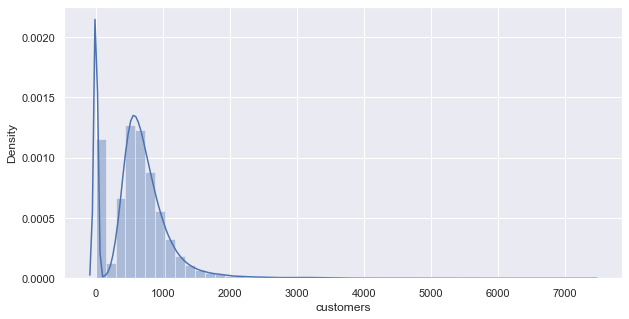

In [309]:
sns.distplot(df1['customers'])

<AxesSubplot:xlabel='sales', ylabel='Density'>

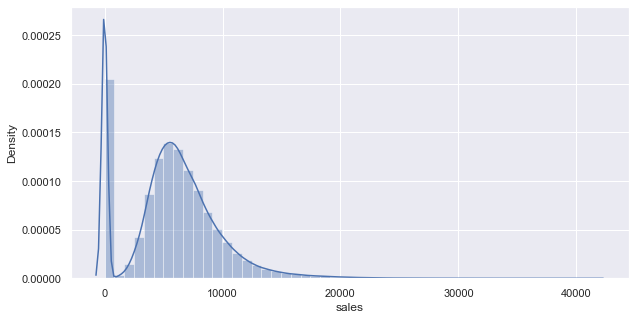

In [310]:
sns.distplot(df1['sales'])

### 1.7.2 Categorical Attributes

<AxesSubplot:xlabel='state_holiday', ylabel='sales'>

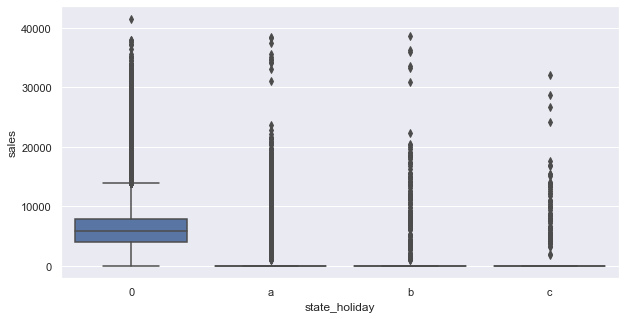

In [311]:
# Iremos utilizar boxplot para exibir a distribuiçãdo dos dados categóricos.
# O exemplo abaixo exibe a distribuição das vendas de acordo com os feriados.
sns.boxplot(x='state_holiday', y='sales', data=df1)

<AxesSubplot:xlabel='assortment', ylabel='sales'>

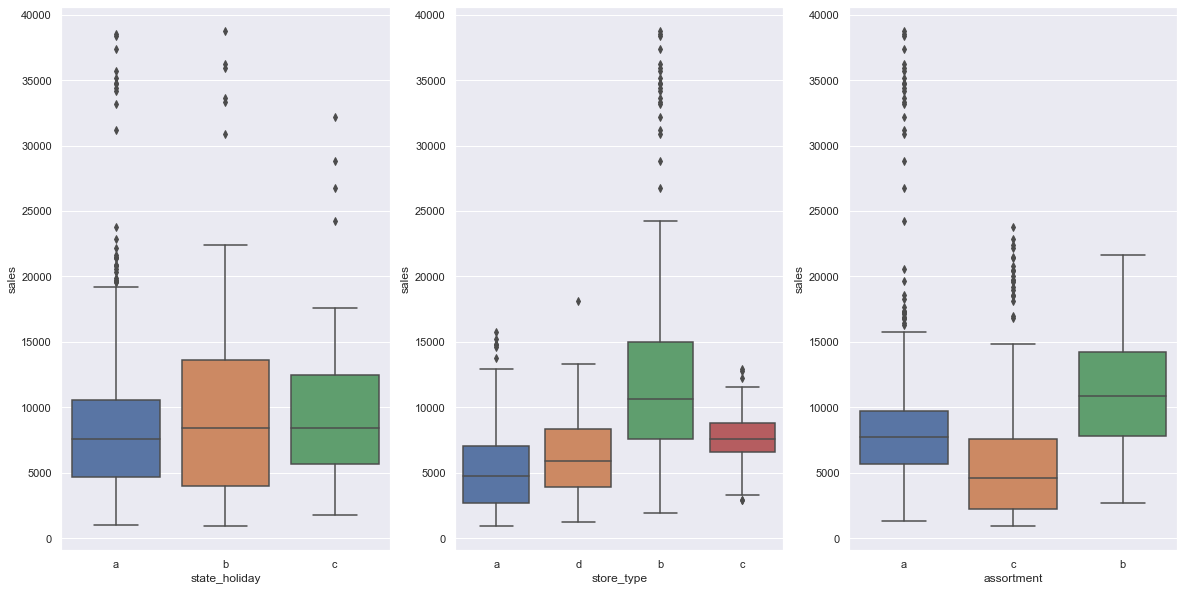

In [312]:
# O exemplo acima exibe uma distribuição muito dispersa dos dados, pois a dimensão das variáveis está muito diferente.
# Isto é muito provavel de ocorrer, pois temos dias que são feriados, onde a loja está fechada e consequentemente a quantidade
# de vendas é zero.
# Neste caso, a coluna 0 que representa dias sem feriados possui um volume de vendas bem maior que as outras três colunas
# a, b e c que são feriados: a = public holiday, b = Easter holiday, c = Christmas.
# Desta maneira, iremos criar dois boxplots separados, um para os dias normais e outro para os feriados.
# O exemplo abaixo considera os dias que são feriados, onde a loja estava aberta, isto é, com vendas diferentes de zero.
aux1 = df1[(df1['state_holiday'] != '0') & (df1['sales'] > 0)]

plt.figure(figsize=(20,10))

plt.subplot (1,3,1)  # Uma linha, três colunas e primeira posição.
sns.boxplot(x='state_holiday', y='sales', data=aux1)

plt.subplot (1,3,2)  # Uma linha, três colunas e segunda posição.
sns.boxplot(x='store_type', y='sales', data=aux1)

plt.subplot (1,3,3)  # Uma linha, três colunas e terceira posição.
sns.boxplot(x='assortment', y='sales', data=aux1)

<AxesSubplot:xlabel='assortment', ylabel='sales'>

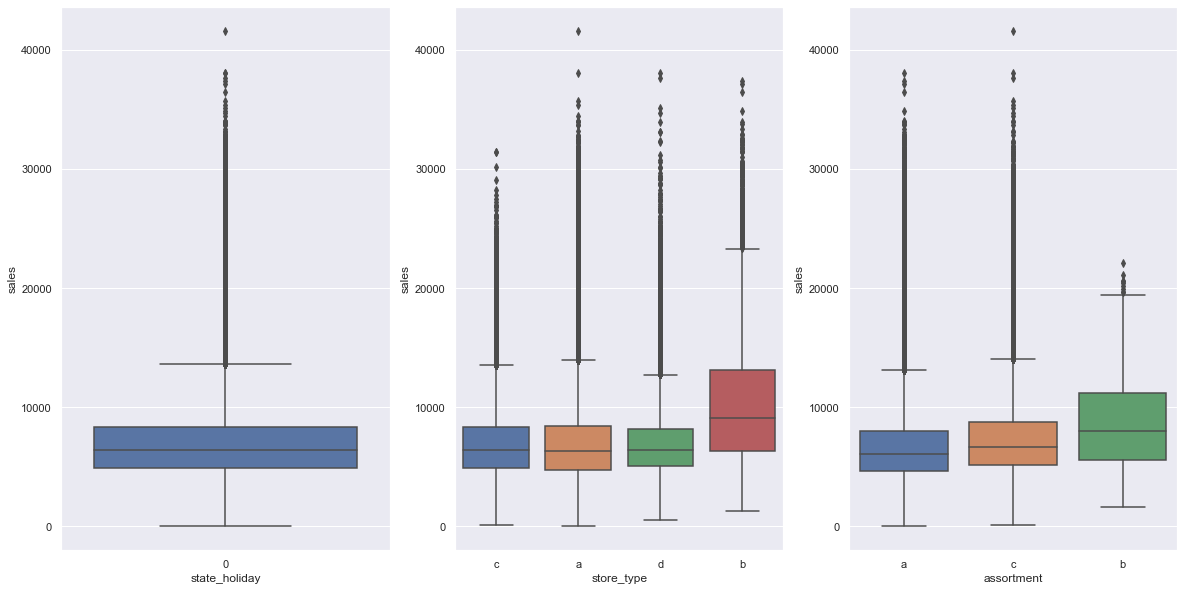

In [313]:
# O exemplo acima exibe uma distribuição muito dispersa dos dados, pois a dimensão das variáveis está muito diferente.
# Isto é muito provavel de ocorrer, pois temos dias que são feriados, onde a loja está fechada e consequentemente a quantidade
# de vendas é zero.
# Neste caso, a coluna 0 que representa dias sem feriados possui um volume de vendas bem maior que as outras três colunas
# a, b e c que são feriados: a = public holiday, b = Easter holiday, c = Christmas.
# Desta maneira, iremos criar dois boxplots separados, um para os dias normais e outro para os feriados.
# O exemplo abaixo considera os dias que não são feriados, onde a loja estava aberta, isto é, com vendas diferentes de zero.
aux2 = df1[(df1['state_holiday'] == '0') & (df1['sales'] > 0)]

plt.figure(figsize=(20,10))

plt.subplot (1,3,1)  # Uma linha, três colunas e primeira posição.
sns.boxplot(x='state_holiday', y='sales', data=aux2)

plt.subplot (1,3,2)  # Uma linha, três colunas e segunda posição.
sns.boxplot(x='store_type', y='sales', data=aux2)

plt.subplot (1,3,3)  # Uma linha, três colunas e terceira posição.
sns.boxplot(x='assortment', y='sales', data=aux2)

In [314]:
# A linha do meio representa a mediana (quartil 50).
# A linha inferior da caixa é o auartil 25.
# A linha superior da caixa é o quartil 75.
# A barra supeior é o valor máximo.
# A barra inferior é o valor mínimo.
# Os pontos acima e abaixo das barras são os outliers. Os dados são considerados outliers quando possuem três vezes o valor do
# desvio padrão.

# 2.0. PASSO 02 - FEATURE ENGINEERING

In [315]:
df2 = df1.copy()

## 2.1. Mapa Mental de Hipóteses

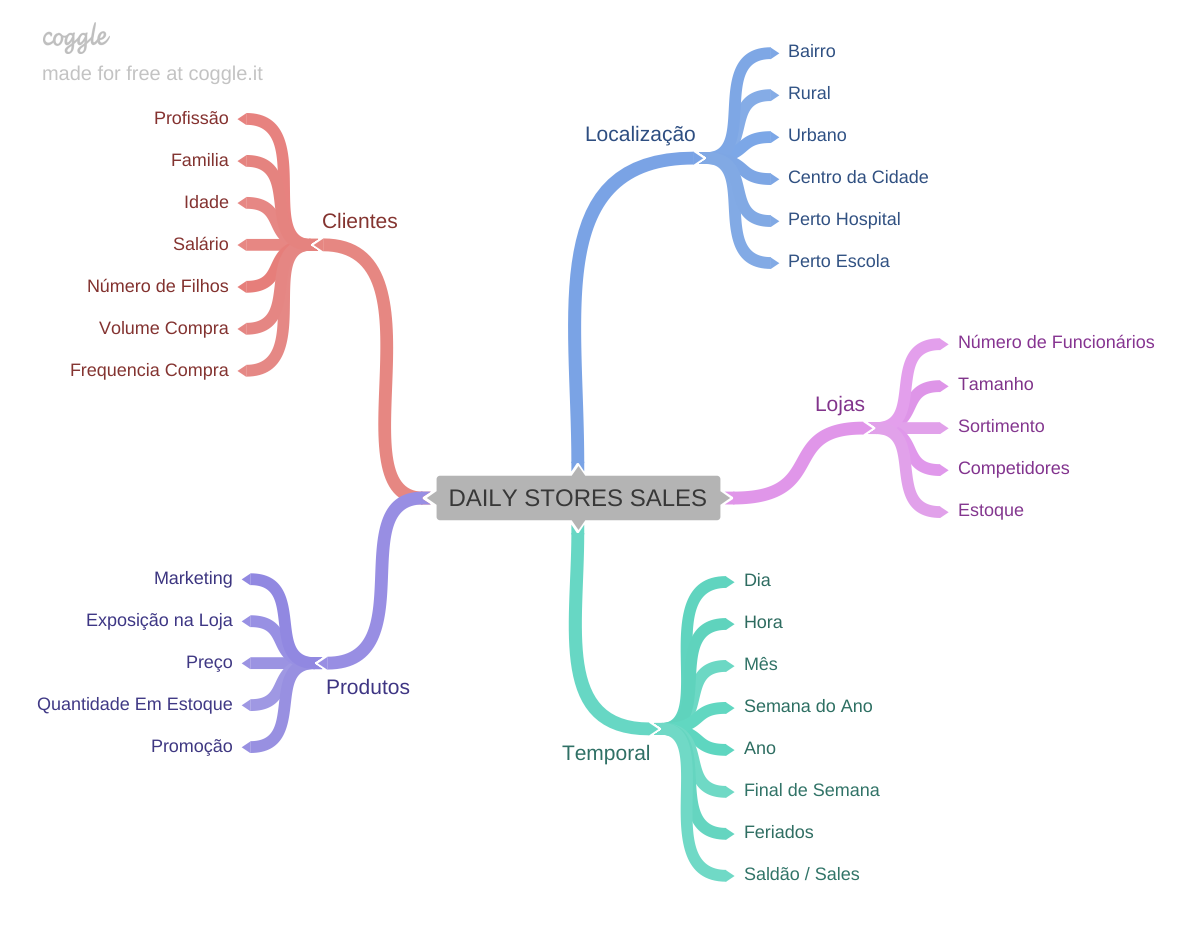

In [316]:
Image ('img/MindMapHipothesis.png')

## 2.2. Criação das Hipóteses

### 2.1.1. Hipóteses Lojas

**1.** Lojas com número maior de funcionários deveriam vender mais.

**2.** Lojas com maior capacidade de estoque deveriam vender mais.

**3.** Lojas com maior porte deveriam vender mais.

**4.** Lojas com maior sortimento deveriam vender mais.

**5.** Lojas com competidores mais próximos deveriam vender menos.

**6.** Lojas com competidores à mais tempo deveriam vender mais.

### 2.1.2. Hipóteses Produto

**1.**Lojas que investem mais em Marketing deveriam vender mais.

**2.**Lojas com maior exposição de produto deveriam vender mais.

**3.**Lojas com produtos com preço menor deveriam vender mais.

**4.**Lojas com promoções mais agressivas (descontos maiores), deveriam vender mais.

**5.**Lojas com promoções ativas por mais tempo deveriam vender mais.

**6.**Lojas com mais dias de promoção deveriam vender mais.

**7.**Lojas com mais promoções consecutivas deveriam vender mais.

### 2.1.3. Hipóteses Tempo

**1.**Lojas abertas durante o feriado de Natal deveriam vender mais.

**2.**Lojas deveriam vender mais ao longo dos anos.

**3.**Lojas deveriam vender mais no segundo semestre do ano.

**4.**Lojas deveriam vender mais depois do dia 10 de cada mês.

**5.**Lojas deveriam vender menos aos finais de semana.

**6.**Lojas deveriam vender menos durante os feriados escolares.

## 2.3. Lista Final de Hipóteses

**1.**Lojas com maior sortimento deveriam vender mais.

**2.**Lojas com competidores mais próximos deveriam vender menos.

**3.**Lojas com competidores à mais tempo deveriam vender mais.

**4.**Lojas com promoções ativas por mais tempo deveriam vender mais.

**5.**Lojas com mais dias de promoção deveriam vender mais.

**6.**Lojas com mais promoções consecutivas deveriam vender mais.

**7.**Lojas abertas durante o feriado de Natal deveriam vender mais.

**8.**Lojas deveriam vender mais ao longo dos anos.

**9.**Lojas deveriam vender mais no segundo semestre do ano.

**10.**Lojas deveriam vender mais depois do dia 10 de cada mês.

**11.**Lojas deveriam vender menos aos finais de semana.

**12.**Lojas deveriam vender menos durante os feriados escolares.

## 2.4. Feature Engineering

In [317]:
# year
# Cria uma coluna "year" contendo o ano da coluna "date".
df2['year'] = df2['date'].dt.year

# month
# Cria uma coluna "month" contendo o mês da coluna "date".
df2['month'] = df2['date'].dt.month

# day
# Cria uma coluna "day" contendo o dia da coluna "date".
df2['day'] = df2['date'].dt.day

# week of year
# Cria uma coluna "week_of_year" contendo a semana do ano da coluna "date".
df2['week_of_year'] = df2['date'].dt.isocalendar().week

# year week
# Cria uma coluna "year_week" contendo o número do ano e o número da semana da coluna "date".
df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

# competition since
# Cria uma coluna competition_since contendo a informação do ano da coluna competition_open_since_year, o valor do mês da
# coluna competition_open_since_month e o valor do dia igual à 1.
df2['competition_since'] = df2.apply(lambda x: datetime.datetime( year=x['competition_open_since_year'], month=x['competition_open_since_month'], day=1), axis=1)
# Cria uma coluna competition_time_month contendo o valor em meses de quanto tempo existe um competidor. Este valor é a 
# diferença da data da coluna "date" com o valor da data da coluna "competition_since", dividindo o resultado por 30 para
# obtermos a quantidade de meses.
# Utiliza-se a função lambda x: x.days para extrair a quantidade de dias da diferença das colunas "date" e "competition_since".
# Neste caso, como dividimos previamente o resultado por 30, a quantidade de dias será a quantidade de dias dividido por 30.
# O objetivo é obtermos a quantidade de meses e não a quantidade de dias, por isso o valor dos dias foi dividido por 30.
# Por último, converte o valor para um número inteiro com a função astype(int).
df2['competition_time_month'] = ((df2['date'] - df2['competition_since'])/30).apply(lambda x: x.days).astype(int)

# promo since
# Cria uma coluna chamada "promo_since" contendo o valor da coluna "promo2_since_year" e "promo2_since_week", onde ambos os 
# valores serão convertidos para string com a função astype(str) e entre estes valores serão acrescentado o caractere "-".
df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)
# Converte o valor da coluna 'promo_since' para o formato data utilizando a função strptime.
df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime(x + '-1', '%Y-%W-%w') - datetime.timedelta(days=7))
# Cria uma coluna chamada "promo_time_week" contendo o valor em semanas de quanto tempo existe uma promoção. Este valor é a 
# diferença da data da coluna "date" com o valor da data da coluna "promo_since", dividindo o resultado por 7 para
# obtermos a quantidade de semanas.
# Utiliza-se a função lambda x: x.days para extrair a quantidade de dias da diferença das colunas "date" e "promo_since".
# Neste caso, como dividimos previamente o resultado por 7, a quantidade de dias será a quantidade de dias dividido por 7.
# O objetivo é obtermos a quantidade de semanas e não a quantidade de dias, por isso o valor dos dias foi dividido por 7.
# Por último, converte o valor para um número inteiro com a função astype(int).
df2['promo_time_week'] = ((df2['date'] - df2['promo_since'])/7).apply(lambda x: x.days).astype(int)


# assortiment
# Altera os valores da coluna "assortiment" de a para "basic", b para "extra" e c para "extended".
df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')

# state holiday
# Altera os valores da coluna "state_holiday" de a para "public_holiday", b para "easter_holiday" e c para 'christimas'
df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day')

In [318]:
df2.sample(5).T

,606790,669753,672608,184287,45486
store,1016,424,1049,313,887
day_of_week,6,5,3,1,7
date,2014-01-04 00:00:00,2013-11-08 00:00:00,2013-11-06 00:00:00,2015-02-16 00:00:00,2015-06-21 00:00:00
sales,3712,7334,3816,10566,0
customers,393,765,623,919,0
open,1,1,1,1,0
promo,0,1,1,1,0
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,0,0,0,0,0
store_type,c,d,a,d,d


In [319]:
df2[df2['state_holiday'] == 'public_holiday'][['state_holiday']]

,state_holiday
63555,public_holiday
63557,public_holiday
63559,public_holiday
63560,public_holiday
63563,public_holiday
...,...
1017204,public_holiday
1017205,public_holiday
1017206,public_holiday
1017207,public_holiday


# 3.0. PASSO 03 - FILTRAGEM DE VARIÁVEIS

In [320]:
df3 = df2.copy()

In [321]:
df3.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,...,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,555,1,1,regular_day,1,c,...,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,625,1,1,regular_day,1,a,...,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,821,1,1,regular_day,1,a,...,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1498,1,1,regular_day,1,c,...,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,559,1,1,regular_day,1,a,...,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0


## 3.1. Filtragem das Linhas

In [322]:
# O primeiro passo é a filtragem das linhas para diminuir o volume do dataset, aumentando o desempenho.

In [323]:
# Coluna open: 1 significa que a loja está aberta e 0 significa que a loja está fechada. Se a loja está fechada não ocorre
# vendas. Portanto, iremos descartas as linhas que possuem na coluna open o valor igual à 0.

In [324]:
# Coluna sales: quando a loja está fechada o valor da coluna sales é igual à zero. Portanto, iremos descartas as linhas que
# possuem na coluna sales o valor igual à 0.

In [325]:
# Mantém apenas as linhas que possuem na coluna open o valor diferente de zero e na coluna sales o valor maior que zero.
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

## 3.2. Seleção das Colunas e das Linha

In [326]:
# Coluna customers: informa quantas pessoas havia na loja no dia que foram feitas as vendas. Se utilizarmos esta coluna 
# iremos necessitar dela no momento da predição e baseado no contexto deste projeto, não temos a informação de quantos 
# clientes/customers teremos daqui à seis semanas. Teríamos que fazer um projeto separado para prever quantos clientes estariam
# nas lojas daqui à seis semanas, pegar o resultado e utilizá-lo como input neste projeto. Porém, não iremos fazer isto.
# Portanto, a coluna customers é uma variável que não temos disponível no momento da predição, significando que é uma
# restrição de negócio.

In [327]:
# Coluna open: uma vez que selecionamos no passo anterior apenas as linhas que possuem na coluna open o valor diferente de
# zero, isto é, o valor igual à 1, não teremos variabilidade nesta coluna, pois todos os valores serão igual à um. Portanto,
# podemos excluir a coluna open.

In [328]:
# Coluna que utilizamos para derivar variáveis ou como colunas auxiliares:
# Coluna promo_interval foi utilizada para derivar a coluna is_promo. Portanto, a coluna promo_interval será excluída.
# Coluna month_map foi uma coluna auxiliar utilizada que será excluída.

In [329]:
# Cria uma lista chamada cols_drop selecionando as colunas que será apagadas do dataset.
cols_drop = ['customers', 'open',  'promo_interval', 'month_map']
df3 = df3.drop (cols_drop, axis = 1)

In [330]:
df3.columns

Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'state_holiday',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo', 'year', 'month',
       'day', 'week_of_year', 'year_week', 'competition_since',
       'competition_time_month', 'promo_since', 'promo_time_week'],
      dtype='object')

# 4.0. PASSO 04 - ANÁLISE EXPLORATÓRIA DE DADOS

In [331]:
df4 = df3.copy()

## 4.1. Análise Univariada

### 4.1.1. Response Variable

<AxesSubplot:xlabel='sales', ylabel='Density'>

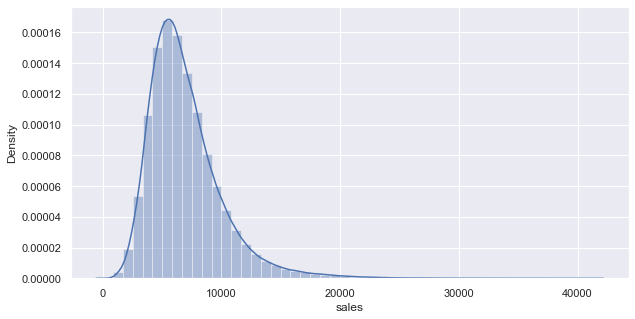

In [332]:
# Exibe a distribuição da variável sales.
sns.set_theme(style="darkgrid")
sns.distplot(df4['sales'])

<AxesSubplot:xlabel='sales', ylabel='Count'>

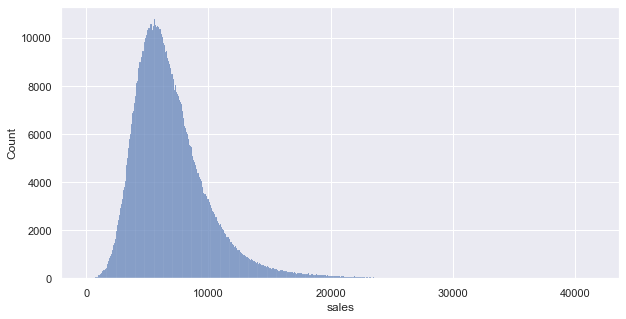

In [333]:
# No gráfico acima, os valores da coluna Y são pequenos pois informam a densidade de distribuição.
# Para exibirmos as quantidades utilizamos o histograma, conforme o exemplo abaixo:
sns.set_theme(style="darkgrid")
sns.histplot(df4['sales'])

<AxesSubplot:xlabel='sales'>

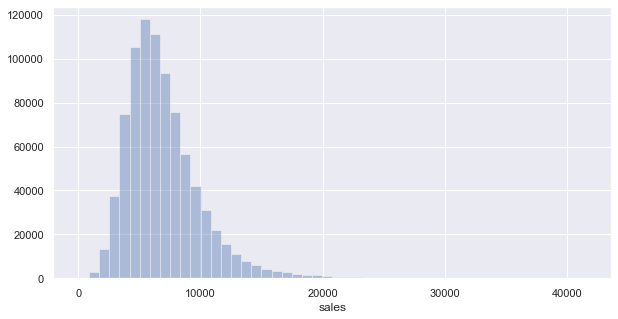

In [334]:
# No gráfico que exibe a distribuição da variável sales, os valores da coluna Y são pequenos pois informam a densidade de 
# distribuição.
# Para exibirmos as quantidades utilizamos o atributeo kde=False, conforme o exemplo abaixo:
sns.set_theme(style="darkgrid")
sns.distplot(df4['sales'], kde=False)

<AxesSubplot:xlabel='sales', ylabel='Density'>

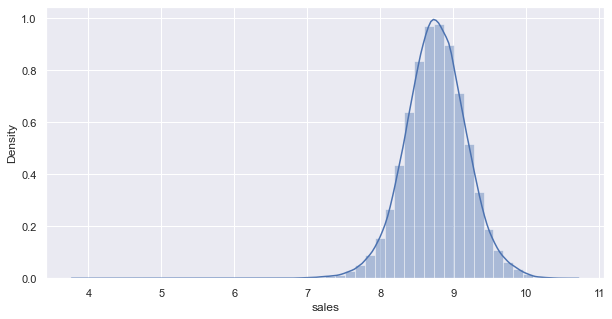

In [335]:
# O gráfico acima mostra uma distribuição com um formato de um sino e com uma skew positiva (cauda da distribuição para
# o lado direito).
# Esta distribuição está bem próxima de uma distribuição normal.
# Nos importamos com estas características da distribuição, pois a maioria dos algoritmos de Machine Learning são criados
# baseados em algumas premissas, baseados em alguns comportamentos do ambiente. Uma destas condições é que os dados sejam 
# independentes e que sigam uma distribuição normal.
# Então quanto mais normal for a distribuição da variável resposta, melhor o seu algoritmo vai performar.
# Existem várias técnicas de transformações para transformar a distribuição da variável resposta mais próxima de uma
# distribuição normal.
# Uma das transformações mais utilizadas é a log. No exemplo abaixo, estamos multiplicando todos os valores de venda pelo log,
# e vai fazer uma modificação na variável resposta.
# A distribuição fica mais próxima de uma distribuição normal.
sns.set_theme(style="darkgrid")
sns.distplot(np.log1p (df4['sales']))

### 4.1.2. Numerical Variable

In [336]:
# Exibe as variáveis numéricas:
num_attributes.head()

,store,day_of_week,sales,customers,open,promo,school_holiday,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo
0,1,5,5263,555,1,1,1,1270.0,9,2008,0,31,2015,0
1,2,5,6064,625,1,1,1,570.0,11,2007,1,13,2010,1
2,3,5,8314,821,1,1,1,14130.0,12,2006,1,14,2011,1
3,4,5,13995,1498,1,1,1,620.0,9,2009,0,31,2015,0
4,5,5,4822,559,1,1,1,29910.0,4,2015,0,31,2015,0


<Figure size 1440x1440 with 0 Axes>

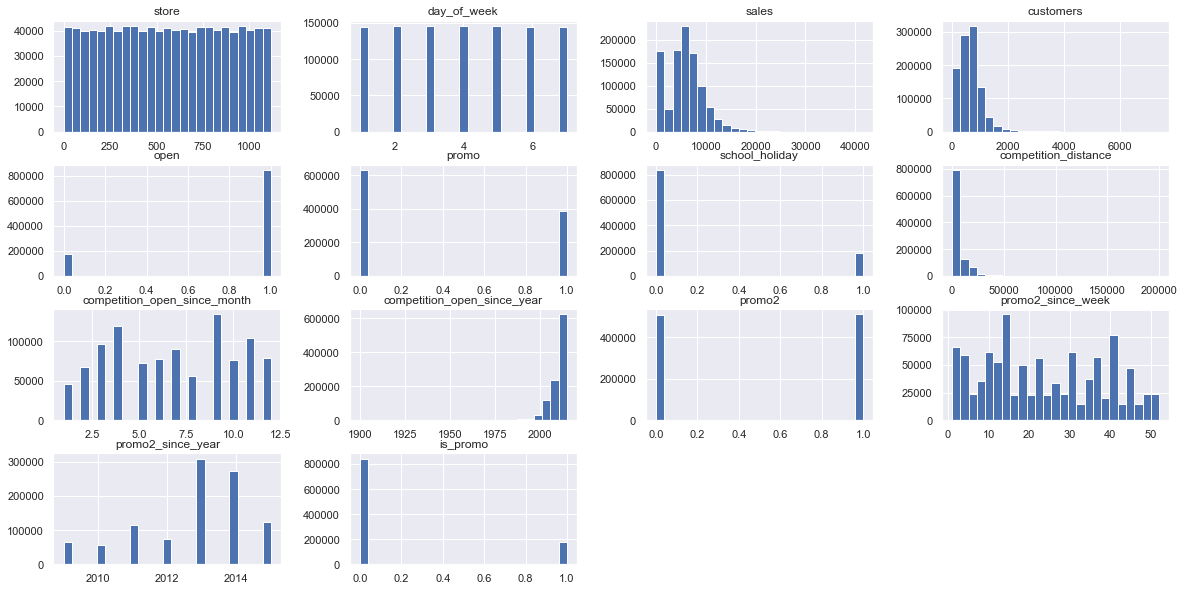

In [337]:
# Exibe os gráficos de histograma para as variáveis numéricas.
plt.figure(figsize=(20,20))
sns.set_theme(style="darkgrid")
num_attributes.hist(bins=25,figsize=(20,10)); # O ponto e vírgulo no final inibe as mensagens de "AxesSubplot".

In [338]:
# FAZER COMO EXERCÍCIO UMA LISTA, EXPLICANDO O COMPORTAMENTO DE CADA VARIÁVEL.
# EXEMPLO: CUSTOMERS TENHO MAIS VENDA QUANDO ESTÁ PERTO DE 30.000. 

### 4.1.3. Categorical Variable

In [339]:
# Exibe as variáveis categóricas.
cat_attributes.head()

,state_holiday,store_type,assortment,promo_interval,month_map
0,0,c,a,0,Jul
1,0,a,a,"Jan,Apr,Jul,Oct",Jul
2,0,a,a,"Jan,Apr,Jul,Oct",Jul
3,0,c,c,0,Jul
4,0,a,a,0,Jul


In [340]:
# Exibe os valores da coluna state_holiday.
df4['state_holiday'].unique()

array(['regular_day', 'public_holiday', 'easter_holiday', 'christmas'],
      dtype=object)

In [341]:
# store type
# Exibe os valores da coluna store_type.
df4['store_type'].unique()

array(['c', 'a', 'd', 'b'], dtype=object)

In [342]:
# assortment
# Exibe os valores da coluna assortment.
df4['assortment'].unique()

array(['basic', 'extended', 'extra'], dtype=object)

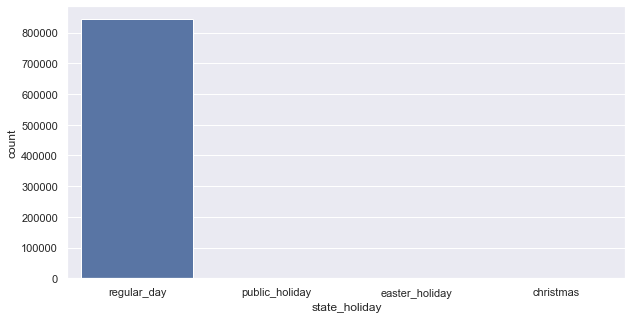

In [343]:
# state holiday
# Exibe a quantidade de linhas para cada valor da coluna state_holiday.
sns.set(rc={"figure.figsize":(10, 5)}) #width=10, height=5
sns.set_theme(style="darkgrid")
sns.countplot(x=df4['state_holiday']); #o ponto e vírgula inibe a mensagem <AxesSubplot:xlabel='state_holiday', ylabel='count'>

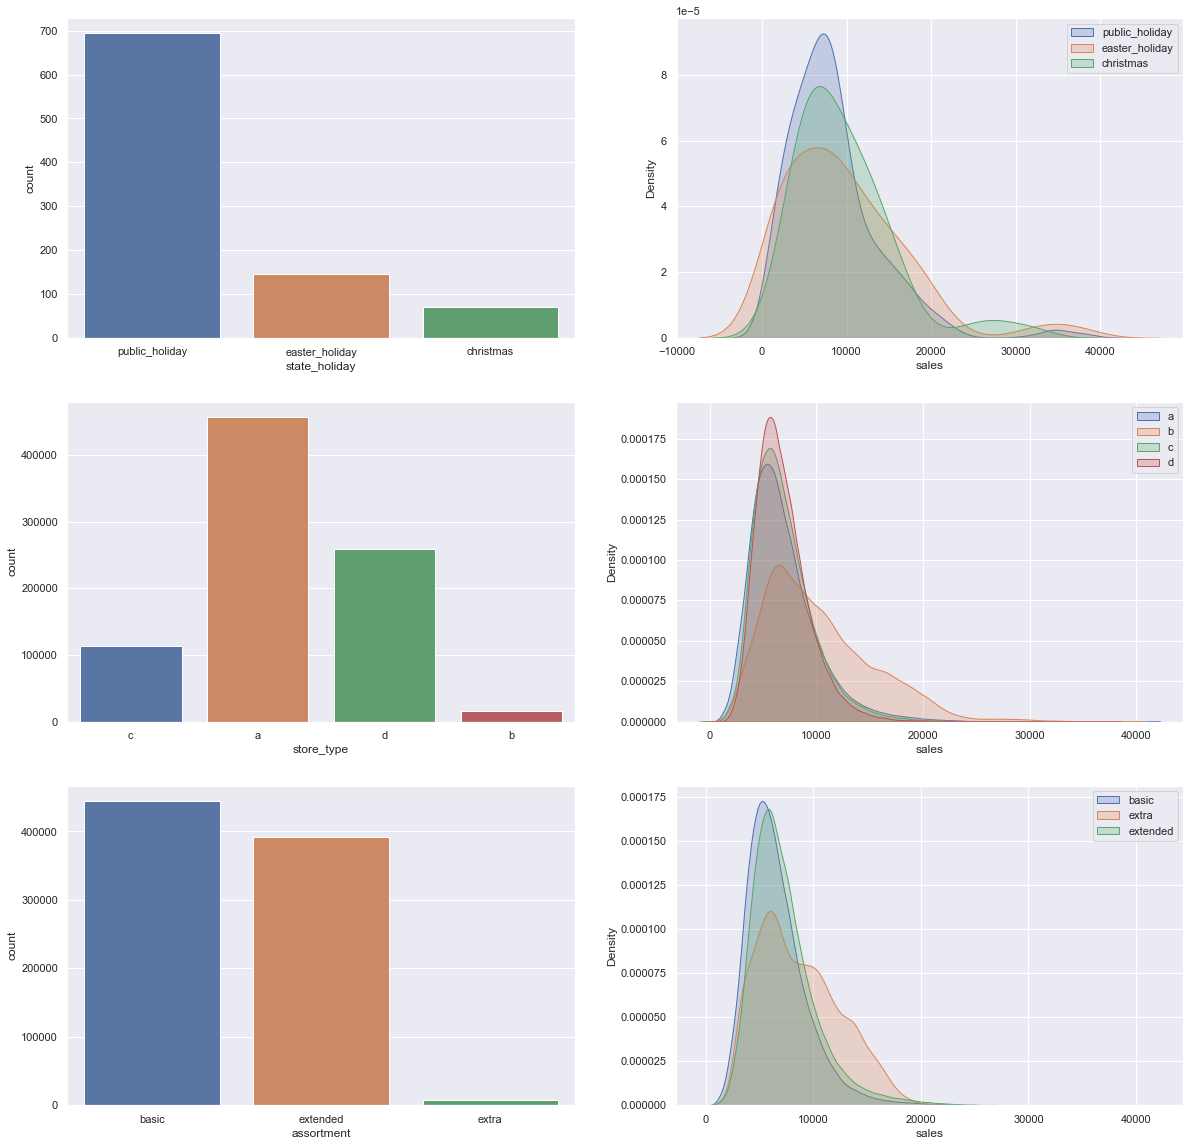

In [344]:
# Exibe os gráficos de ocorrencia e densidade de vendas para os atributos state_holiday, store_type e assortment.
plt.figure(figsize=(20,20))
sns.set_theme(style="darkgrid")

# O comando abaixo inibe a mensagem de warning: " FutureWarning: Pass the following variable as a keyword arg: x. From 
# version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword
# will result in an error or misinterpretation. warnings.warn("
warnings.filterwarnings('ignore')

# state_holiday
plt.subplot(3,2,1)  # Três linhas, duas colunas, primeira posição.
# Exibe a quantidade de ocorrencias para cada tipo de feriado (state_holiday), excluíndo os dias normais.
a = df4[df4['state_holiday'] != 'regular_day']
sns.countplot(a['state_holiday'])

plt.subplot(3,2,2)
# Exibe o gráfico de densidade de vendas (kde: kernel density estimation) para o atributo state_holiday, excluíndo os dias normais:
sns.kdeplot(df4[df4['state_holiday'] == 'public_holiday']['sales'], label='public_holiday', shade=True)
sns.kdeplot(df4[df4['state_holiday'] == 'easter_holiday']['sales'], label='easter_holiday', shade=True)
sns.kdeplot(df4[df4['state_holiday'] == 'christmas']['sales'], label='christmas', shade=True)
plt.legend()  # Exibe as legendas.

# store_type
plt.subplot(3,2,3)
# Exibe a quantidade de ocorrências para cada tipo de loja (store_type).
sns.countplot(df4['store_type'])

plt.subplot(3,2,4)
# Exibe o gráfico de densidade de vendas (kde: kernel density estimation) para o atributo store_type':
sns.kdeplot(df4[df4['store_type'] == 'a']['sales'], label='a', shade=True)
sns.kdeplot(df4[df4['store_type'] == 'b']['sales'], label='b', shade=True)
sns.kdeplot(df4[df4['store_type'] == 'c']['sales'], label='c', shade=True)
sns.kdeplot(df4[df4['store_type'] == 'd']['sales'], label='d', shade=True)
plt.legend()  # Exibe as legendas.

# assortment
plt.subplot(3,2,5)
# Exibe a quantidade de ocorrências para cada tipo de sortimento (assortment).
sns.countplot(df4['assortment'])

plt.subplot(3,2,6)
# Exibe o gráfico de densidade de vendas (kde: kernel density estimation) para o atributo store_type':
sns.kdeplot(df4[df4['assortment'] == 'basic']['sales'], label='basic', shade=True)
sns.kdeplot(df4[df4['assortment'] == 'extra']['sales'], label='extra', shade=True)
sns.kdeplot(df4[df4['assortment'] == 'extended']['sales'], label='extended', shade=True)

plt.legend()  # Exibe as legendas.

In [345]:
# O gráfico da variavel state_holiday, exibe uma menor distribuição de vendas para os feriados public_holiday, por isto, exibe um pico maior.
# Em compensação o feriado easter_holiday possui uma distribuição de vendas maior, isto é, existem mais lojas que vendem menos e 
# mais lojas que vendem mais quando comparado com os feriados public_holiday.
# O gráfico da variável assortment(sortimento) mostra que o tipo de assortment extra possui uma distribuição de vendas maior do que os outros tipos
# de assortments. Neste caso, o tipo de sortimento extra possui volumes de vendas maiores do que os outros dois tipos de sortimentos.

### TESTE COM OUTRO TIPO DE PLOT

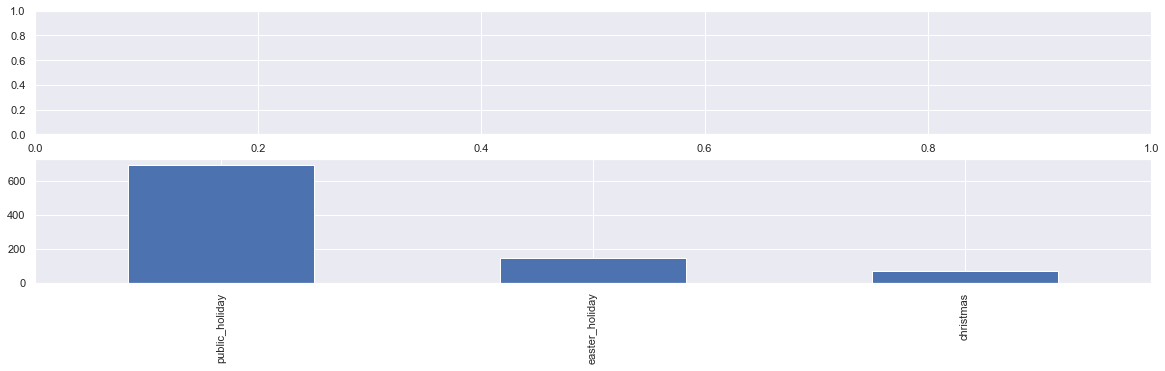

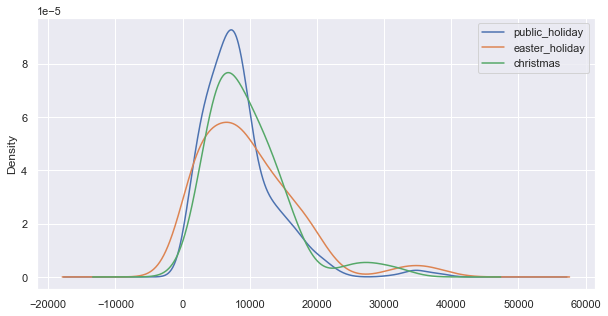

In [346]:
# TESTE COM OUTROS TIPOS DE PLOT.
from matplotlib import pyplot as plt
from matplotlib import gridspec
import seaborn as sns

# Exibe os gráficos de ocorrencia e volume de vendas para os atributos state_holiday, store_type e assortment.
sns.set_theme(style="darkgrid")

# O comando abaixo inibe a mensagem de warning: " FutureWarning: Pass the following variable as a keyword arg: x. From 
# version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword
# will result in an error or misinterpretation. warnings.warn("
warnings.filterwarnings('ignore')

fig = plt.figure( figsize=(20,5))
specs = gridspec.GridSpec(ncols=1, nrows=2, figure=fig)

ax1 = fig.add_subplot(specs[0,0])  # First Row - First Graph
ax2 = fig.add_subplot(specs[1,0])    # First Row - Second Graph

# First Graph
#ax1.bar(df4[df4['state_holiday'] == 'public_holiday'], df4[df4['state_holiday'] == 'easter_holiday'],color=sns.color_palette("mako"), zorder=2)
#a0 = df4[df4['state_holiday'] != 'regular_day']
#ax1.plot(a0)

#a0 = df4[df4['state_holiday'] == 'regular_day'].shape[0]
df0 = df4[df4['state_holiday'] != 'regular_day']
#ax1 = a0.plot.bar()
#sns.countplot(a['state_holiday'])
ax1 = df0['state_holiday'].value_counts().plot(kind='bar')
plt.show()

#ax1 = a0['state_holiday'].value_counts(sort=True).nlargest(10).plot.bar()

#ax = sns.countplot(x='room_type', hue="neighbourhood_group", data=airbnb)
#ax1 = plt.bar(a0)
#plt.show()

# Second Graph
a1 = df4[df4['state_holiday'] == 'public_holiday']['sales']
ax2 = a1.plot.kde()
a2 = df4[df4['state_holiday'] == 'easter_holiday']['sales']
ax2 = a2.plot.kde()
a3 = df4[df4['state_holiday'] == 'christmas']['sales']
ax2 = a3.plot.kde()

plt.legend(['public_holiday', 'easter_holiday', 'christmas'])
plt.show()

In [347]:
list_holiday = []
list_holiday.append(df4[df4['state_holiday'] == 'public_holiday'].shape[0])
list_holiday.append(df4[df4['state_holiday'] == 'easter_holiday'].shape[0])
list_holiday.append(df4[df4['state_holiday'] == 'christmas'].shape[0])
list_holiday

[694, 145, 71]

## 4.2. Análise Bivariada

### **H1.** Lojas com maior sortimento deveriam vender mais.
**FALSA** Lojas com MAIOR SORTIMENTO (EXTENDED) vendem MENOS QUE O ASSORTMENT EXTRA.

In [348]:
# O comando abaixo armazena na variável aux1 a média das vendas por tipo de assortment.
aux1 = df4[['assortment', 'sales']].groupby('assortment').mean().reset_index()

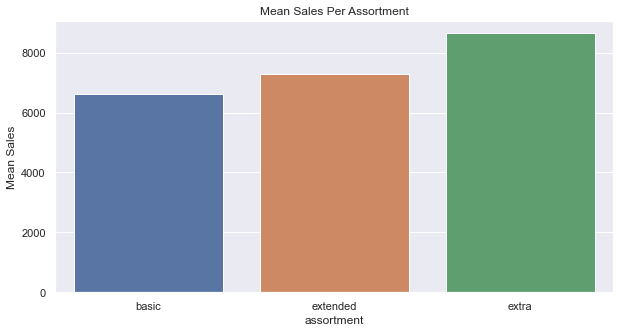

In [349]:
# O comando abaixo exibe o gráfico de barras das médias de vendas para cada tipo de assortment.
sns.barplot(x='assortment', y='sales', data=aux1).set_title('Mean Sales Per Assortment');  # O ponto e virgula inibe a mensagem: <AxesSubplot:xlabel='assortment', ylabel='sales'>
plt.ylabel('Mean Sales');  # Configura o texto da coluna Y.

In [350]:
# O gráfico acima mostra que as lojas com maior sortimento (assortment=extended) vendem menos que o assortment extra, portanto a hipótese é falsa.

#### ANALISE INCORRETA do comportamento da variável assortment, considerando a soma das vendas.

In [351]:
# Uma pergunta que surge é: Será que ocorreu uma mudança de comportamento ao longo do tempo. Por exemplo, imagine que extra
# foi um tipo de assortment que vendeu muito no passado e de uns tempos para cá começou a vender menos.
# Para validar esta hipótese, necessitamos da soma das vendas por assortment e por dia, para verificar se ocorreu alguma 
# mudança ao longo do tempo.
# O comando abaixo armazena na variável aux2 a soma das vendas por tipo de assortment e por semana do ano.
aux2 = df4[['year_week', 'assortment', 'sales']].groupby(['year_week', 'assortment']).sum().reset_index()

In [352]:
aux2.head(5)

,year_week,assortment,sales
0,2013-00,basic,13434262
1,2013-00,extended,12425669
2,2013-00,extra,269404
3,2013-01,basic,26007250
4,2013-01,extended,22917693


In [353]:
# Para exibir um gráfico com uma linha para cada tipo de assortment, tempos que transformar o tipos de assortment em colunas.
# O comando pivot abaixo armazena na variável aux3 um dataset com o indice year_week, as colunas são os tipos de assortment e
# os valores da coluna sales.
aux3 = aux2.pivot(index='year_week', columns='assortment', values='sales')
aux3.head(5)

assortment,basic,extended,extra
year_week,,,
2013-00,13434262,12425669,269404
2013-01,26007250,22917693,350279
2013-02,17970974,16029584,377207
2013-03,24392076,21243431,404662
2013-04,19972891,18130077,363061


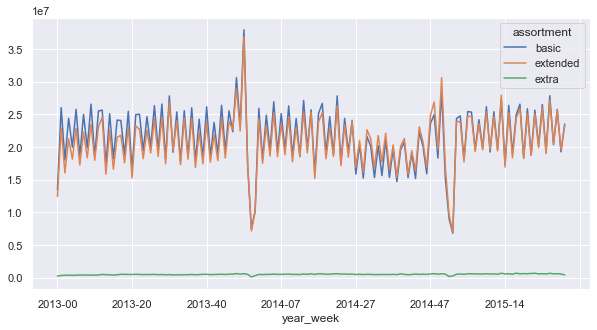

In [354]:
# O comando abaixo exibe um gráfico da soma das vendas por semana do ano para cada tipo de assortment.
aux2.pivot(index='year_week', columns='assortment', values='sales').plot();

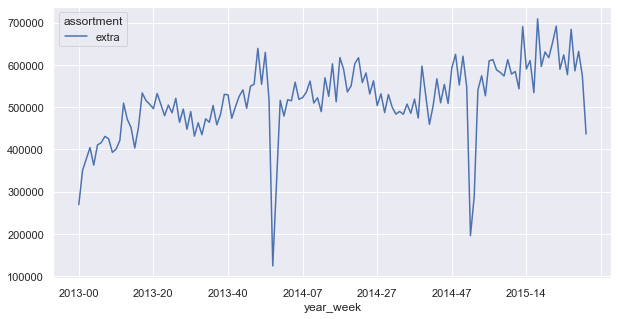

In [355]:
# Podemos concluir no gráfico acima que o comportamento dos tipos de assortment basic e extended são praticamente iguais.
# O volume de vendas dos tipos de assortment basic e extended são muito superiores ao tipo de assortment extra.
# Para visualizar melhor o comportamento do tipo de assortment extra, iremos filtrar no dataset apenas o tipo de assortment
# extra, conforme exemplo abaixo:
# O comando abaixo filtra no dataset os valores de assortment iguais à extra.
aux4 = aux2[aux2['assortment'] == 'extra']
# O comando abaixo exibe um gráfico das vendas das lojas por semana do ano para cada tipo de assortment.
aux4.pivot(index='year_week', columns='assortment', values='sales').plot();

In [356]:
# O gráfico acima mostra que o tipo de assortment extra possui um comportamento que não conseguimos visualizar no gráfico
# anterior que contém todos os tipos de assortment.
# Portanto, se algum valor for muito discrepante que os outros, vale a pena gerar um gráfico separado, como fizemos acima,
# para enxergar algum tipo de comportamento.

#### ANALISE CORRETA do comportamento da variável assortment, considerando a média das vendas.

In [357]:
# Os dois gráficos acima, mostram a soma das vendas por tipo de assortment. Mantive estes gráficos para explicar que quando
# existe uma valor muito discrepante em relação aos outro valores, devemos fazer um gráfico separada para conseguirmos visualizar
# o comportamento deste valor.
# Porém para realizar esta análise, o correto é considerarmos as médias das vendas por tipo de assortment, pois o tipo de assortment
# extra possui uma quantidade muito menor que os outros assortments.
# Portanto, segue abaixo a visualização correta da variável assortment.

In [358]:
# Uma pergunta que surge é: Será que ocorreu uma mudança de comportamento ao longo do tempo. Por exemplo, imagine que extra
# foi um tipo de assortment que vendeu muito no passado e de uns tempos para cá começou a vender menos.
# Para validar esta hipótese, necessitamos da média das vendas por assortment e por dia, para verificar se ocorreu alguma 
# mudança ao longo do tempo.
# O comando abaixo armazena na variável aux5 a media das vendas por tipo de assortment e por semana do ano.
aux5 = df4[['year_week', 'assortment', 'sales']].groupby(['year_week', 'assortment']).mean().reset_index()

In [359]:
aux5.head(5)

,year_week,assortment,sales
0,2013-00,basic,5642.277194
1,2013-00,extended,6094.001471
2,2013-00,extra,5282.431373
3,2013-01,basic,7307.459961
4,2013-01,extended,7553.623270


In [360]:
# Para exibir um gráfico com uma linha para cada tipo de assortment, tempos que transformar o tipos de assortment em colunas.
# O comando pivot abaixo armazena na variável aux6 um dataset com o indice year_week, as colunas são os tipos de assortment e
# os valores da coluna sales.
aux6 = aux5.pivot(index='year_week', columns='assortment', values='sales')
aux6.head(5)

assortment,basic,extended,extra
year_week,,,
2013-00,5642.277194,6094.001471,5282.431373
2013-01,7307.459961,7553.623270,6254.982143
2013-02,5049.444788,5283.317073,6286.783333
2013-03,6853.631919,6983.376397,6423.206349
2013-04,5611.939028,5944.287541,6483.232143


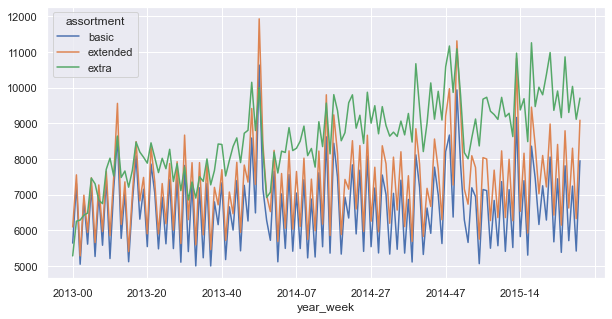

In [361]:
# O comando abaixo exibe um gráfico da média das vendas por semana do ano para cada tipo de assortment.
aux5.pivot(index='year_week', columns='assortment', values='sales').plot();

In [362]:
# No gráfico acima, podemos concluir que o tipo de assortment extra possui um valor médio de vendas
# aumentando ao longo do tempo, enquanto a média das vendas dos tipos de assortment basic e extended
# continua praticamente estável ao longo do tempo.

### **H2.** Lojas com competidores mais próximos deveriam vender menos.
**FALSA** Loja com COMPETIDORES MAIS PRÓXIMOS vendem na MÉDIA.

#### MINHA RESOLUÇÀO CONSIDERANDO A MÉDIA DE VENDAS POR TIPO DE COMPETITION_DISTANCE

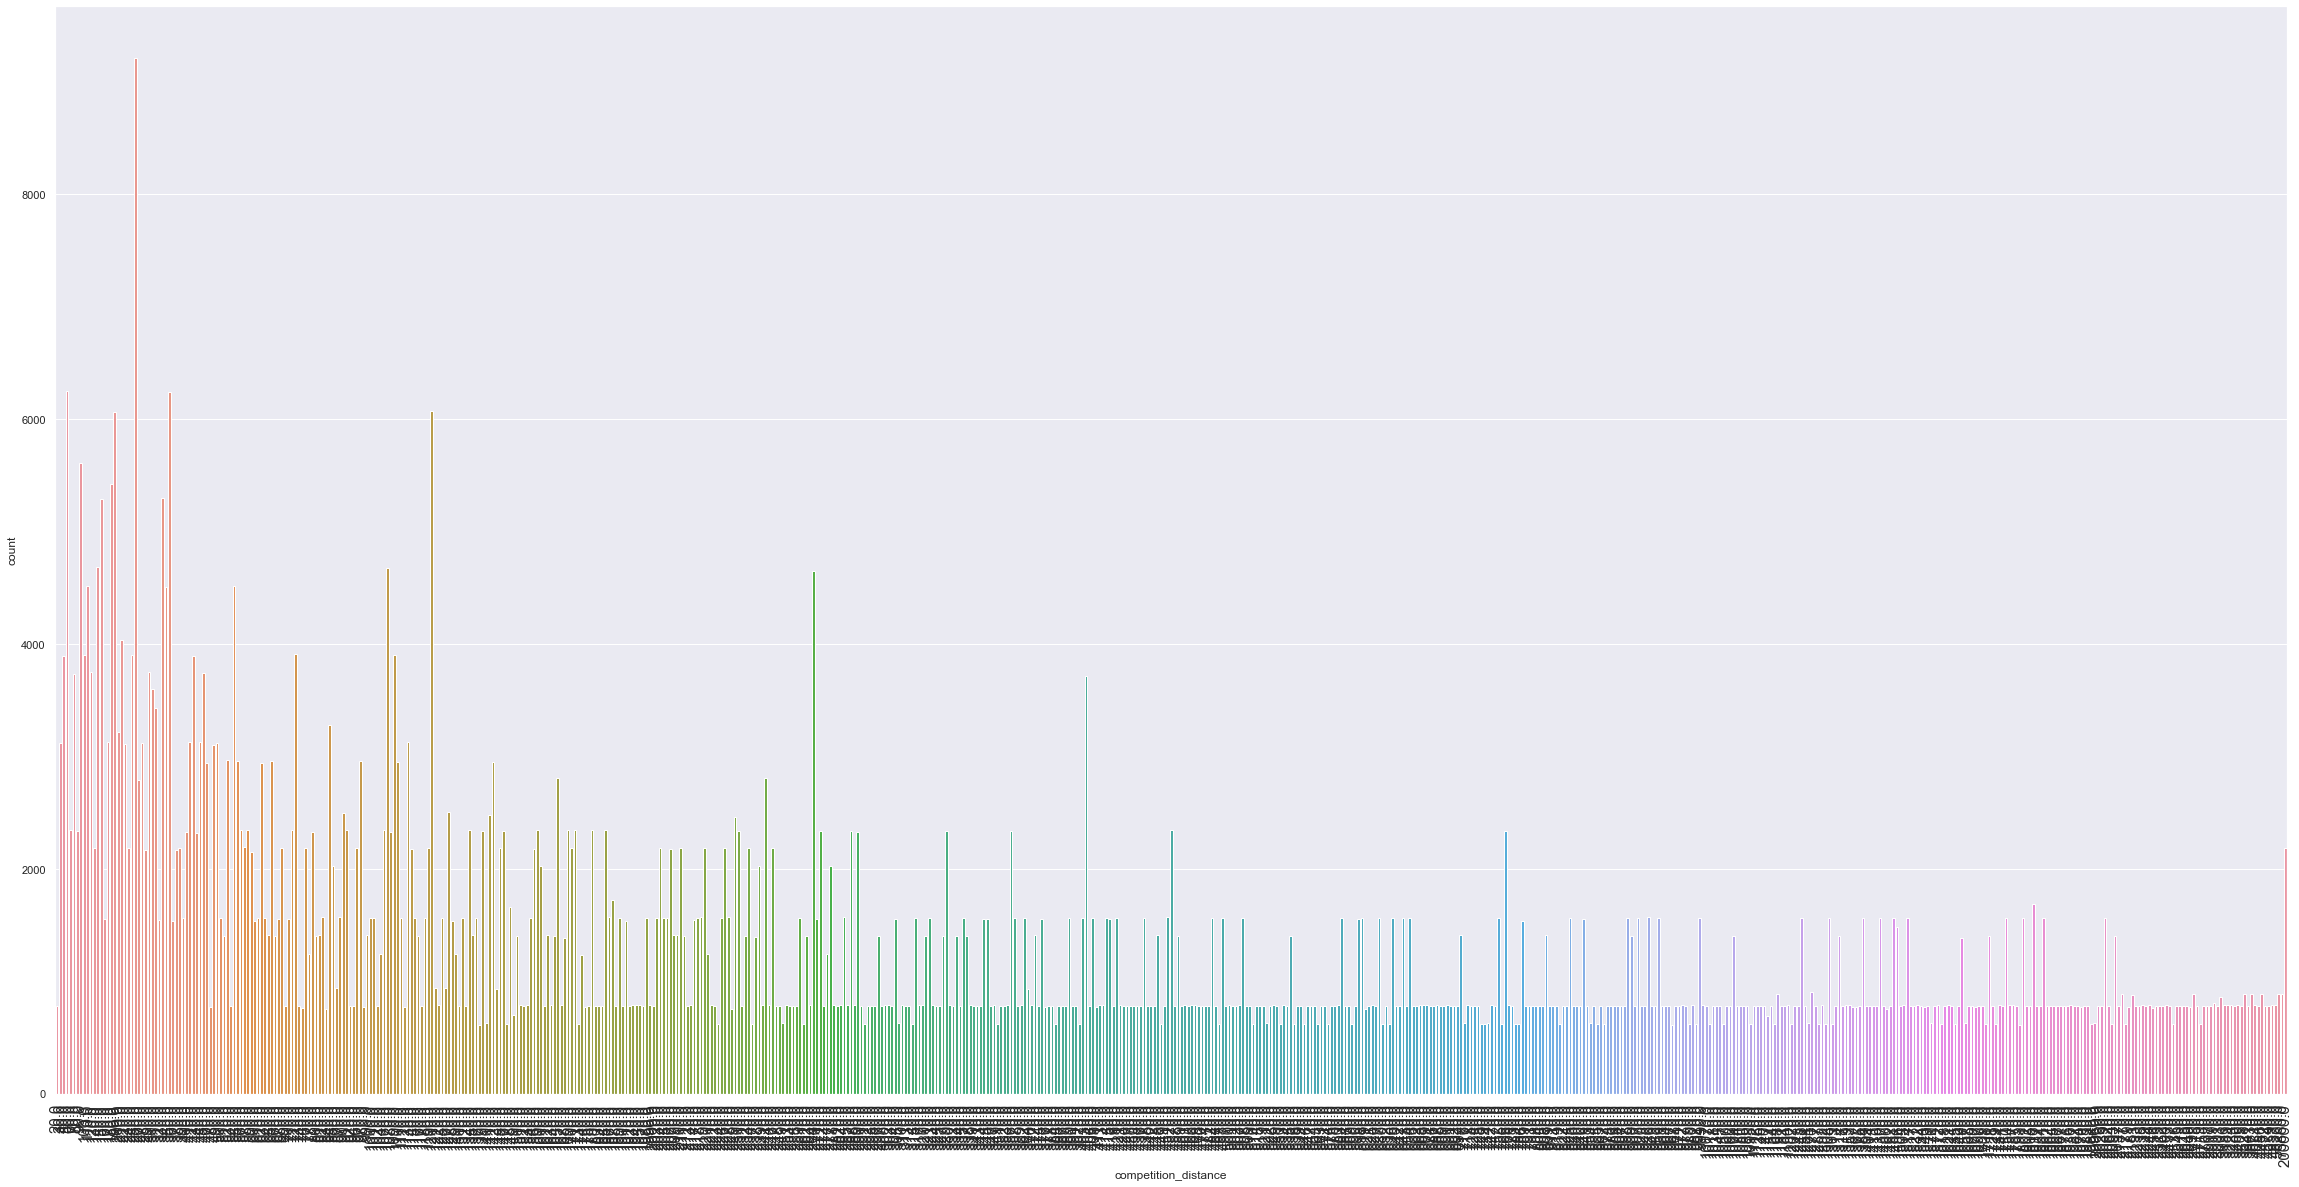

In [363]:
# Gráfico para exibir a quantidade de ocorrências para cada valor de competition_distance.
plt.figure(figsize=(40,20))  # Define o tamanho do gráfico.
sns.countplot(x=df4['competition_distance'])
plt.xticks(rotation=90, fontsize=15);  # Rotaciona o label da coluna x em 90 graus e especifica o tamanho da fonte do label.

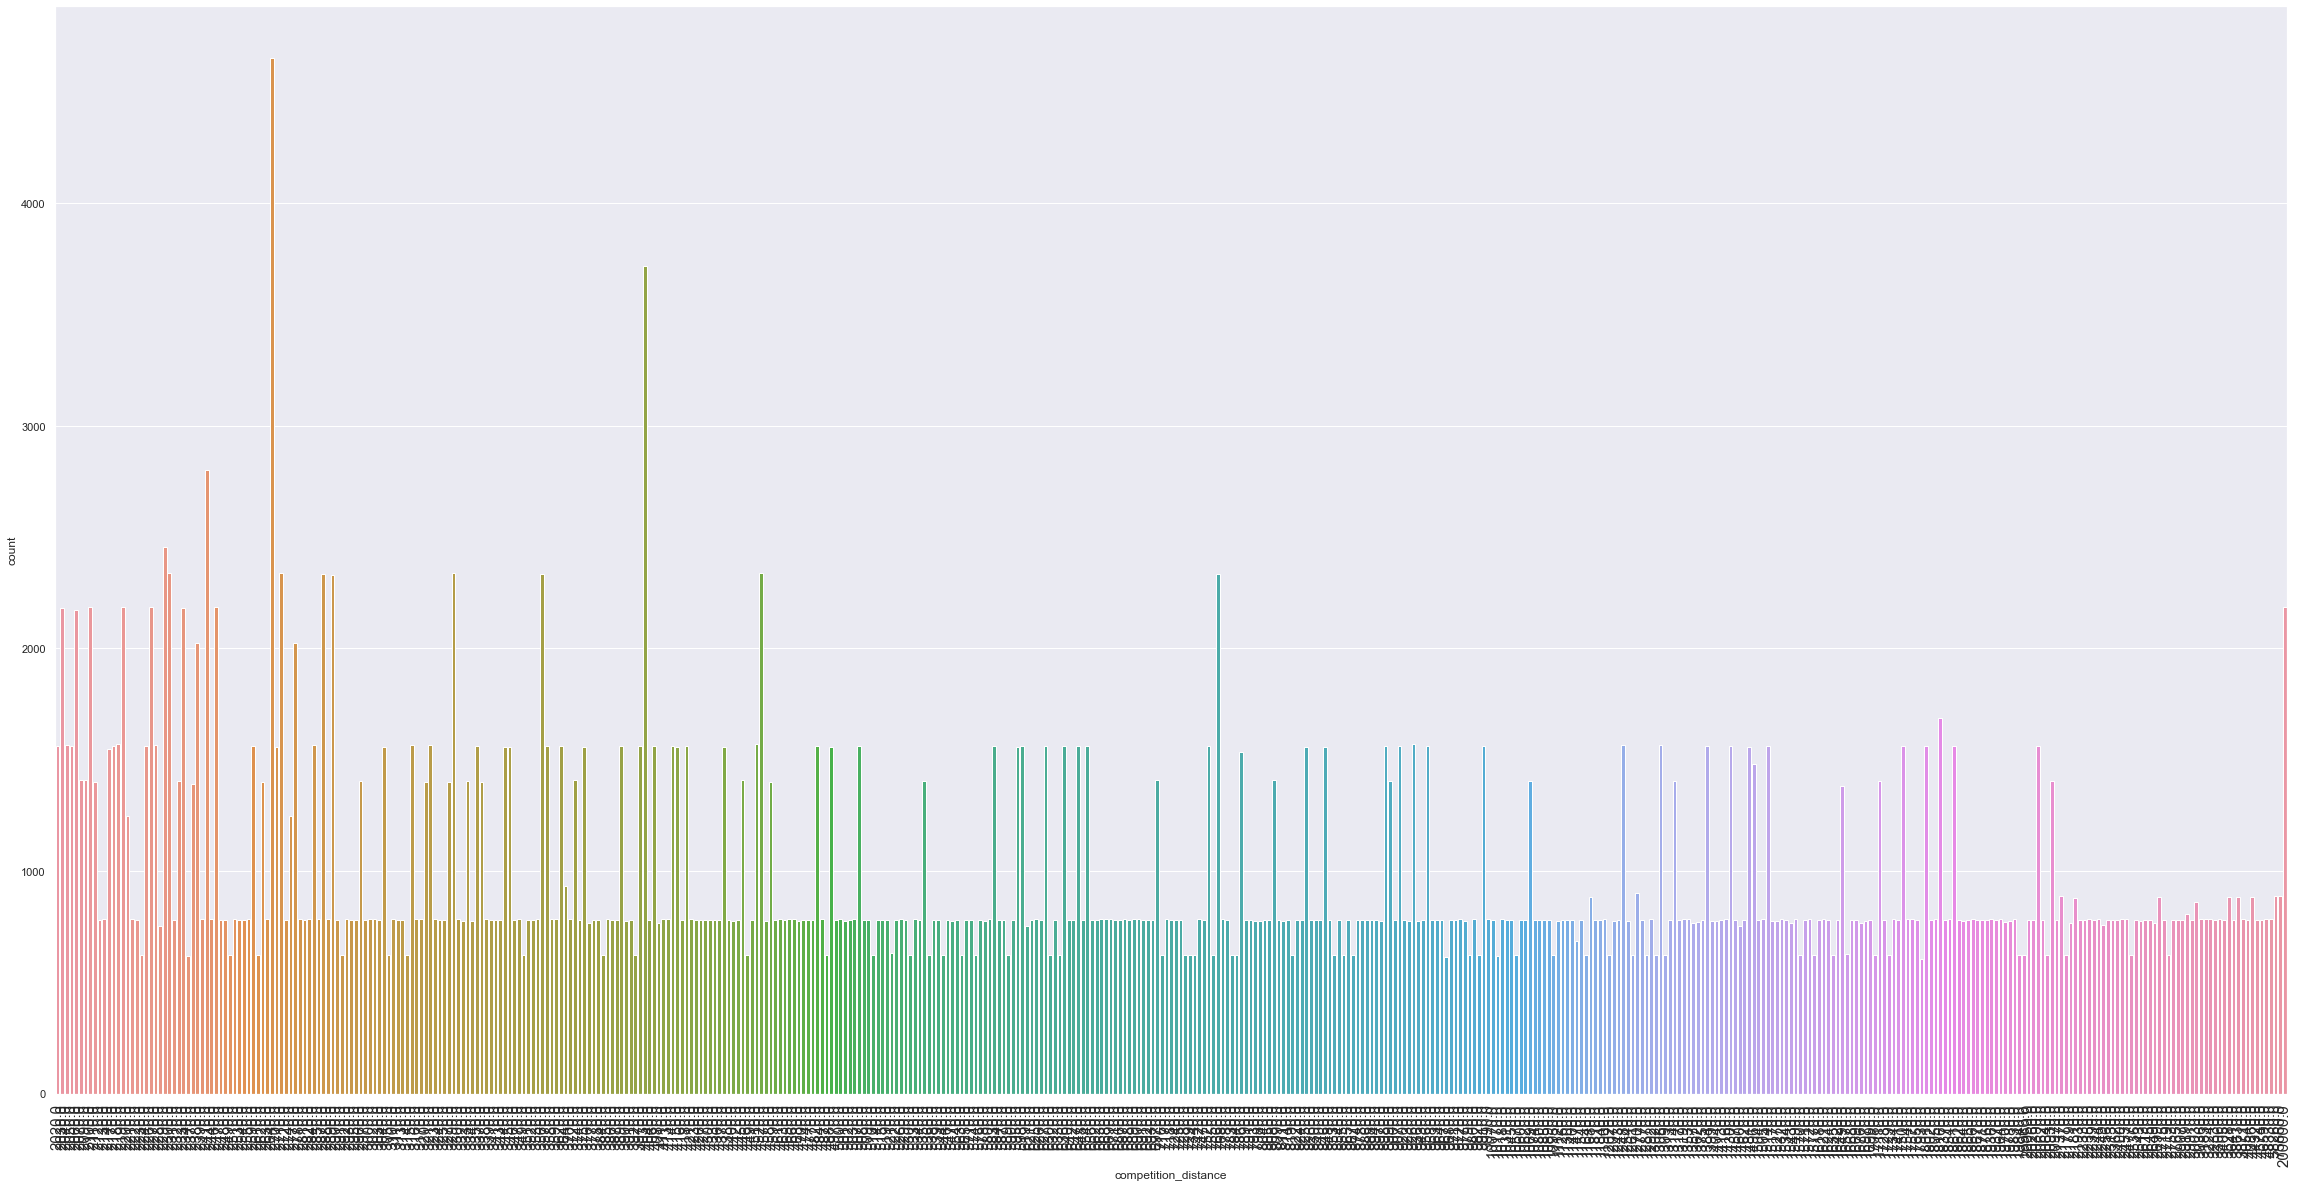

In [364]:
# Gráfico para exibir a quantidade de ocorrências valor de competition_distance > 2000.
plt.figure(figsize=(40,20))  # Define o tamanho do gráfico.
aux19 = df4[(df4['competition_distance'] > 2000 )]
sns.countplot(x=aux19['competition_distance'])
plt.xticks(rotation=90, fontsize=15);  # Rotaciona o label da coluna x em 90 graus e especifica o tamanho da fonte do label.

In [365]:
# No gráfico acima, verificamos que existe um certo padrão na quantidade de lojas por distância, onde um valor próximo de
# 800 lojas se repete ao longo das distâncias.

In [366]:
# O comando abaixo armazena na variável aux9 a média das vendas por tipo de competition_distance.
aux9 = df4[['competition_distance', 'sales']].groupby('competition_distance').mean().reset_index()

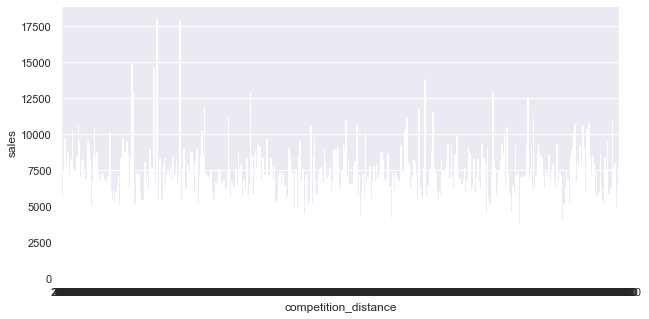

In [367]:
# Exibe a média das vendas por tipo de competition_distance.
sns.barplot(x='competition_distance', y='sales', data=aux9);  # O ponto e virgula inibe a mensagem: <AxesSubplot:xlabel='assortment', ylabel='sales'>

In [368]:
# O gráfico acima é muito granular e é difícil de enxergar alguma coisa. 
# Para visualizar melhor esta informação, podemos criar grupos de distâncias. Exemplo: de 10 em 10 , de 100 e 100, etc...
# Então agrupamos as vendas por grupo de competition_distance.

# O comando bins abaixo, cria uma lista com valores de 0 até 80000 que crescem de 1000 em 1000.
bins = list(np.arange(0, 80000, 1000))

# Temos que saber em qual grupo de 1000 em 1000 o valor da competition_distance fará parte.
# Para isto, utilizamos o método do pandas chamado cut que pega a variável competition_distance e o bins criado anteriormente
# e determina em qual grupo de bins o valor original de competition_distance pertence.
# É criada uma nova coluna chamada competition_distance_binned onde o valor será de acordo com o valor do grupo da coluna
# competition_distance.
aux9['competition_distance_binned'] = pd.cut(aux9['competition_distance'], bins=bins)

In [369]:
aux9.sample(5)

,competition_distance,sales,competition_distance_binned
114,1260.0,7649.296178,"(1000, 2000]"
231,2840.0,7035.179438,"(2000, 3000]"
554,16180.0,6237.314981,"(16000, 17000]"
561,16680.0,8685.312420,"(16000, 17000]"
634,29910.0,4676.274711,"(29000, 30000]"


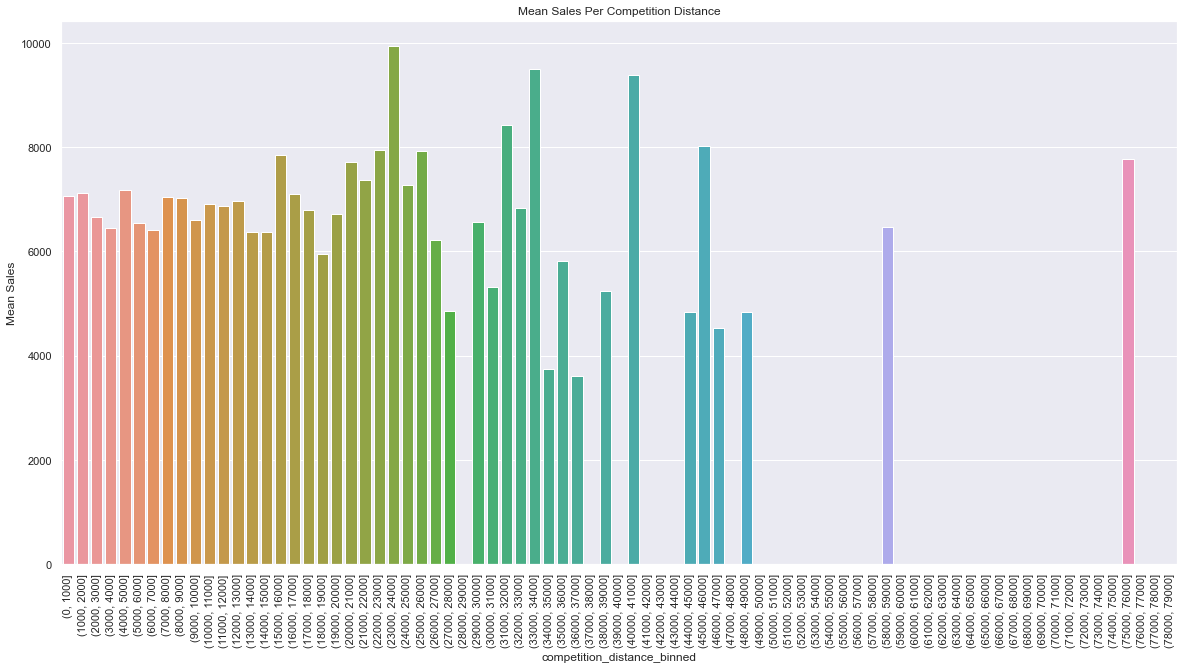

In [370]:
# O comando abaixo exibe um gráfico com a média de vendas por competition_distance_binned.
plt.figure(figsize=(20,10))
aux10 = aux9[['competition_distance_binned', 'sales']].groupby('competition_distance_binned').mean().reset_index()
sns.barplot(x='competition_distance_binned', y='sales', data=aux10).set_title('Mean Sales Per Competition Distance');
plt.xticks(rotation=90); # Rotaciona o label da coluna x em 90 graus.
plt.ylabel('Mean Sales');  # Configura o texto da coluna Y.

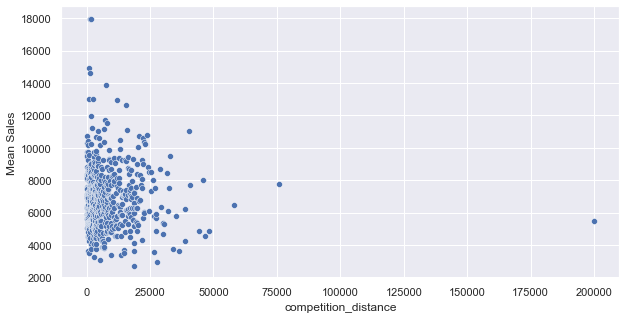

In [371]:
# Exemplo de gráfico utilizando scatter plot:
# O comando abaixo armazena na variável aux11 a média das vendas por tipo de competition_distance.
aux11 = df4[['competition_distance', 'sales']].groupby('competition_distance').mean().reset_index()

# Exibe um gráfico do tipo scatter plot:
sns.scatterplot(x='competition_distance', y='sales', data=aux11);
plt.ylabel('Mean Sales');  # Configura o texto da coluna Y.

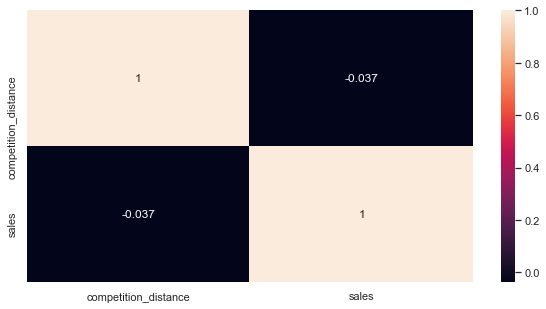

In [372]:
# O gráfico abaixo mede a força da correlação entre as variáveis competition_distance e sales.
sns.heatmap(aux11.corr(method='pearson'), annot=True);
# Os valores da correlação variam de 1 até -1.  Quanto mais próxima de zero, mais fraca é a 
# correlação. Quanto mais próximo de 1 ou -1, mais forte é a correlação.

### **H3.** Lojas com competidores à mais tempo deveriam vender mais.
**FALSO** Lojas com COMPETIDORES À MAIS TEMPO vendem na MÉDIA.

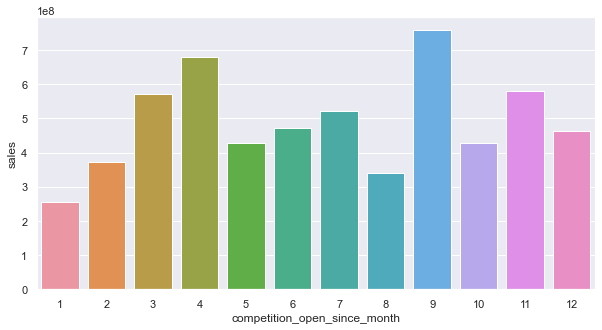

In [373]:
# O comando abaixo armazena na variável aux12 a soma das vendas para cada valor de competition_open_since_month.
aux12 = df4[['competition_open_since_month', 'sales']].groupby('competition_open_since_month').sum().reset_index()

# Exibe um gráfico de barras.
sns.barplot(x='competition_open_since_month', y='sales', data=aux12);

# O gráfico abaixo mostra na coluna x o mês que o competidor iniciou as suas vendas. E a coluna y mostra a soma
# das vendas.
# Este gráfico não é útil, pois estamos interessados em saber qual é a relação entre o tempo que o competidor está
# aberto com as vendas. Neste gráfico se por exemplo um competidor iniciou no mês 9 do ano passado, não temos
# esta informação.

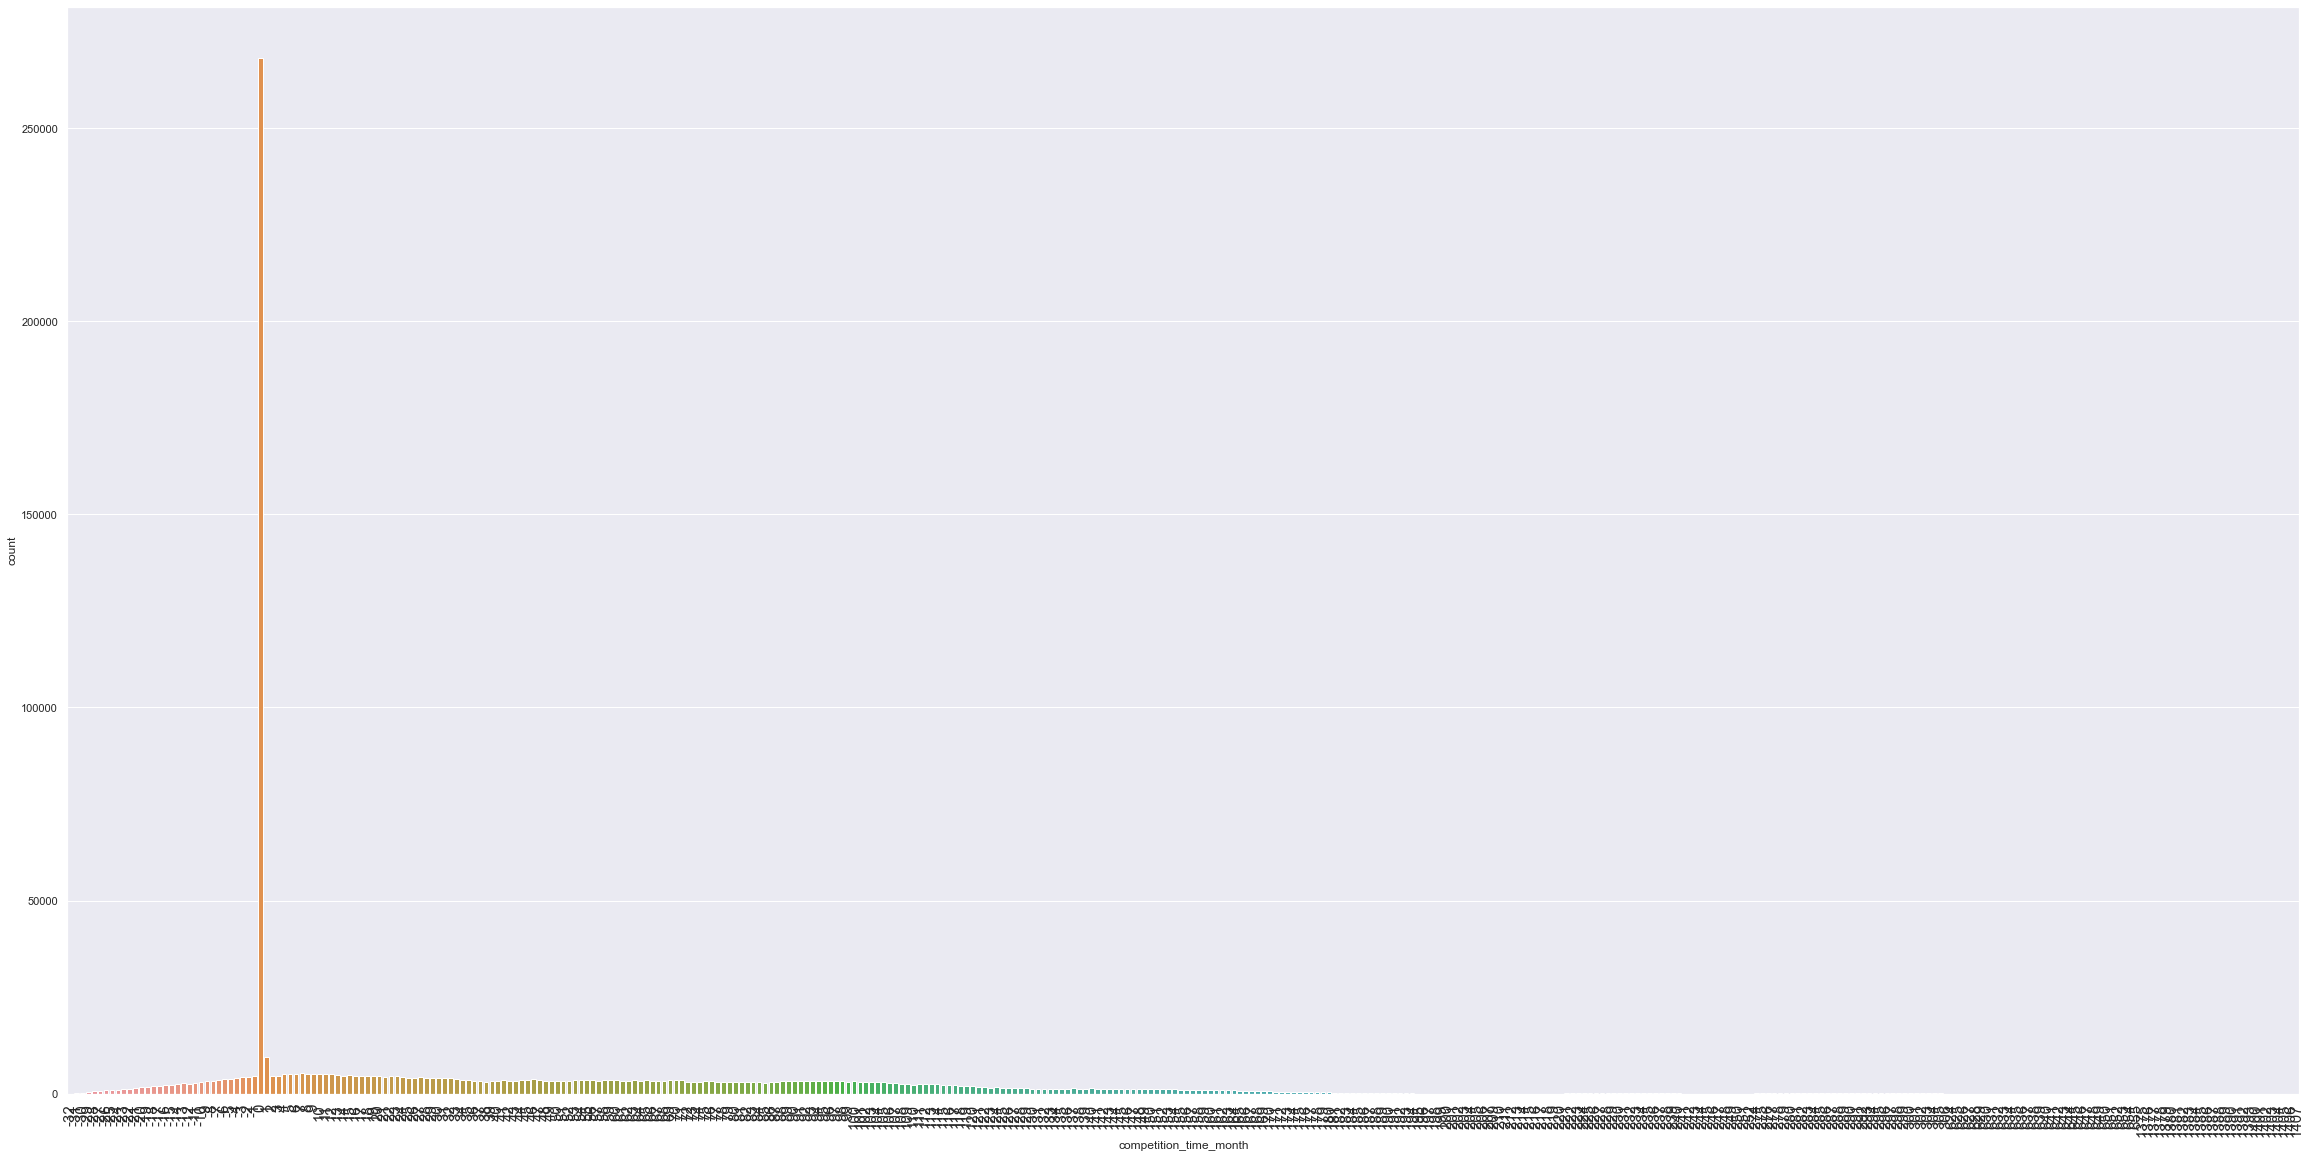

In [374]:
# Para resolver o problema anterior, devemos utilizar a variável competition_time_month que 
# informa quantos meses um competidor iniciou suas vendas.

# Gráfico para exibir a quantidade de ocorrências para cada valor de competition_time_month.
plt.figure(figsize=(40,20))  # Define o tamanho do gráfico.
sns.countplot(x=df4['competition_time_month'])
plt.xticks(rotation=90, fontsize=15);  # Rotaciona o label da coluna x em 90 graus e especifica o tamanho da fonte do label.

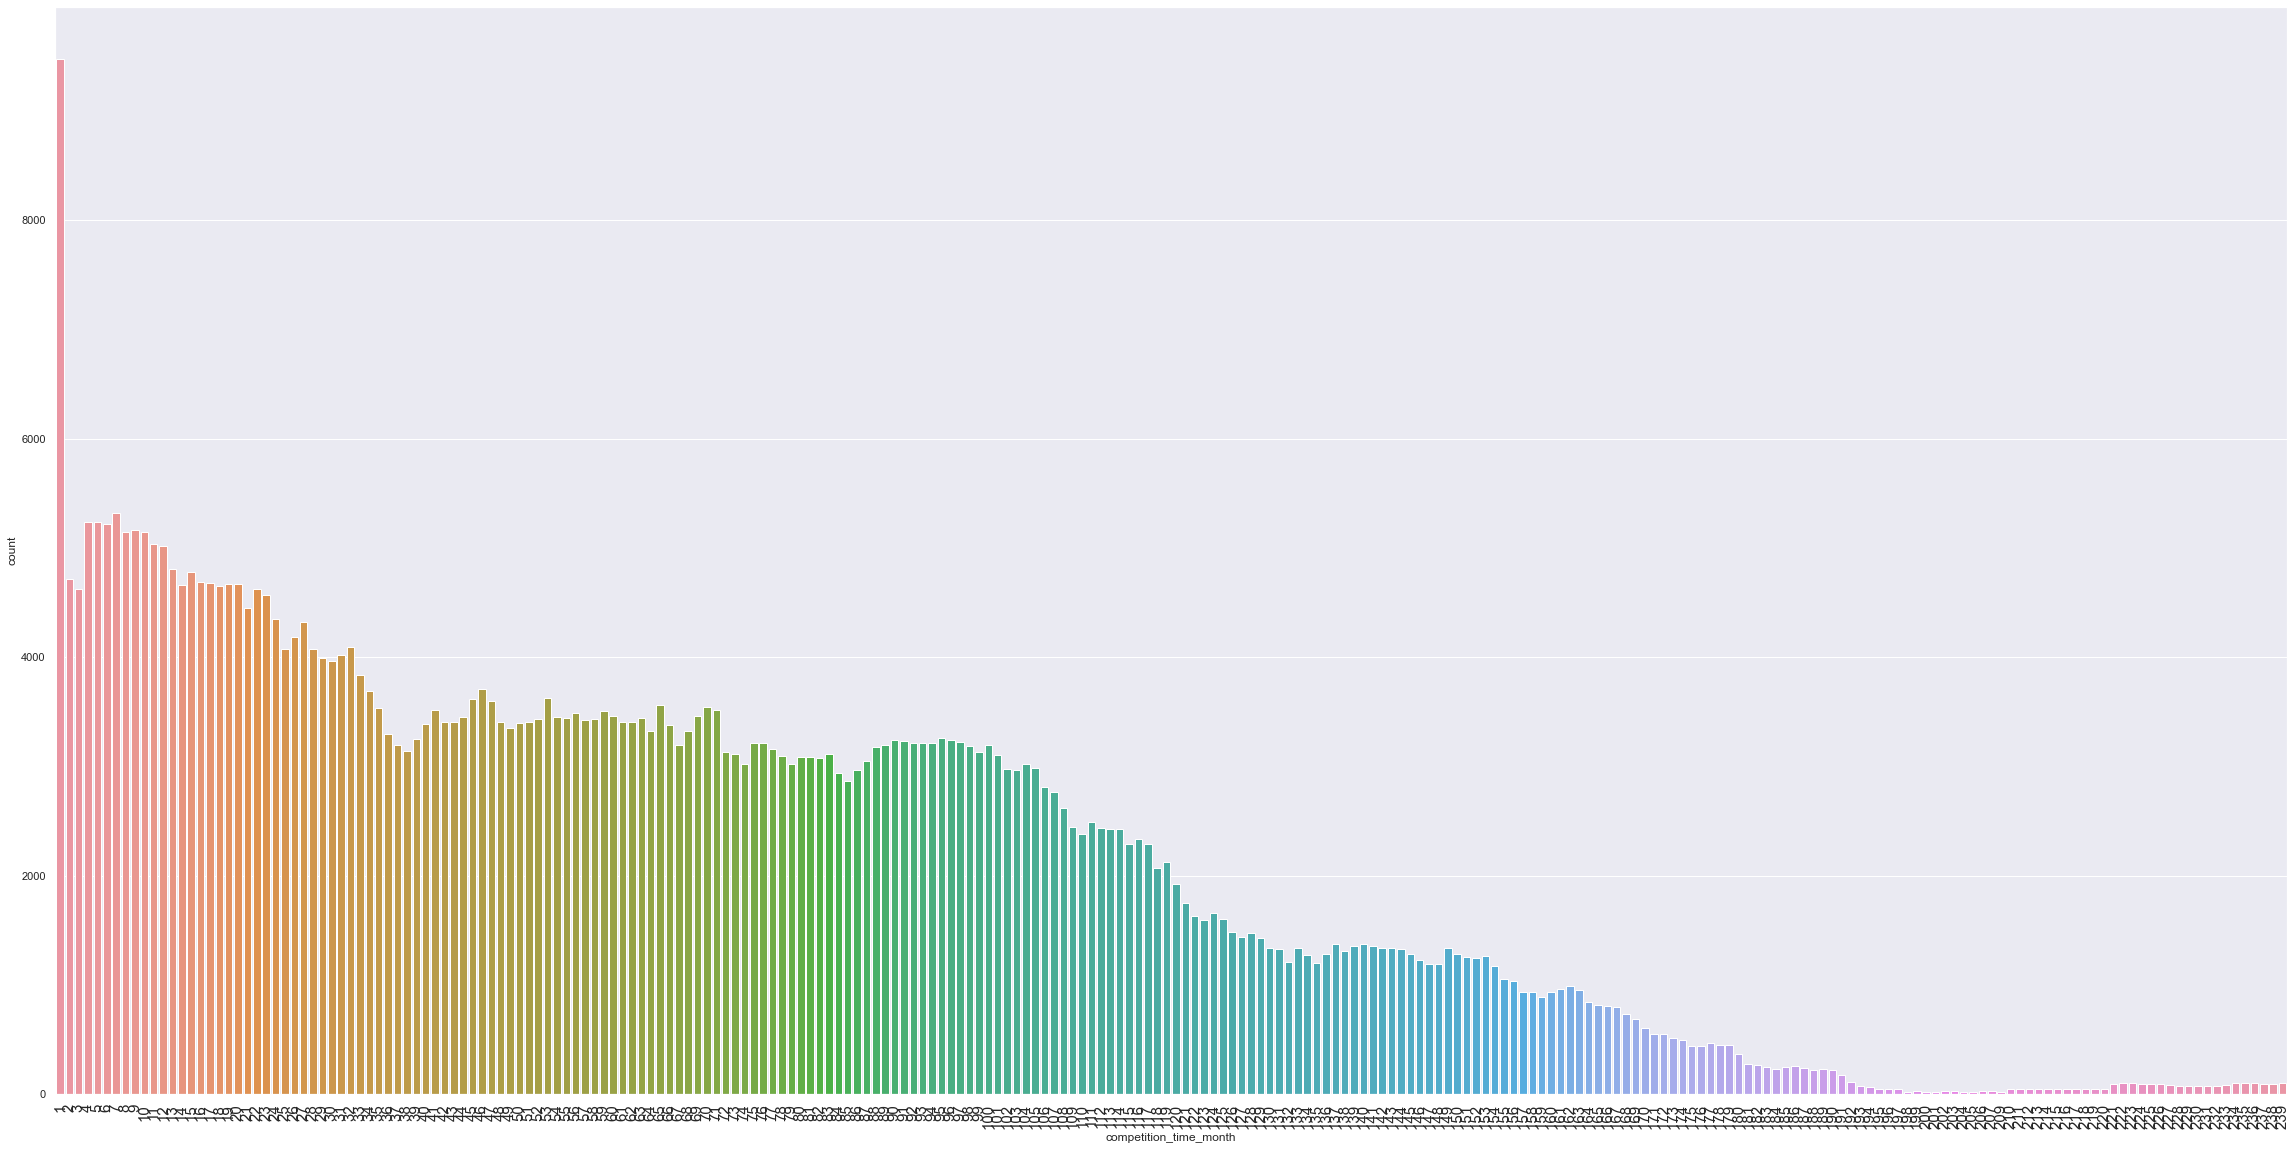

In [375]:
# Para melhorar a visualização do gráfico iremos exibir a quantidade de ocorrências para cada valor de competition_time_month
# considerando um valor maior que 0 e menor que 240.
aux17 = df4[(df4['competition_time_month'] > 0 ) & (df4['competition_time_month'] < 240)]
plt.figure(figsize=(40,20))  # Define o tamanho do gráfico.
sns.countplot(x=aux17['competition_time_month'])
plt.xticks(rotation=90, fontsize=15);  # Rotaciona o label da coluna x em 90 graus e especifica o tamanho da fonte do label.

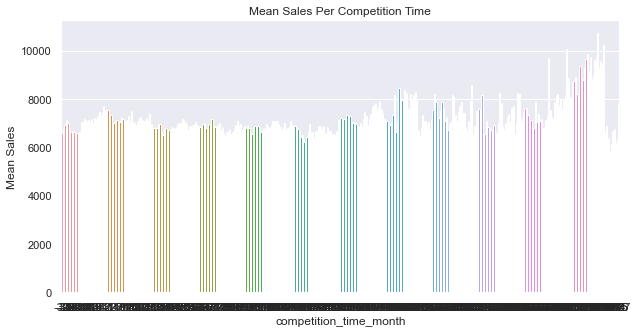

In [376]:
# O comando abaixo armazena na variável aux15 a média das vendas para cada valor de competition_time_month.
aux15 = df4[['competition_time_month', 'sales']].groupby('competition_time_month').mean().reset_index()

# Exibe um gráfico de barras.
sns.barplot(x='competition_time_month', y='sales', data=aux15).set_title('Mean Sales Per Competition Time');
plt.ylabel('Mean Sales');  # Configura o texto da coluna Y.

In [377]:
# No gráfico acima podemos comprovar que lojas com competidores a mais tempo vendem mais.

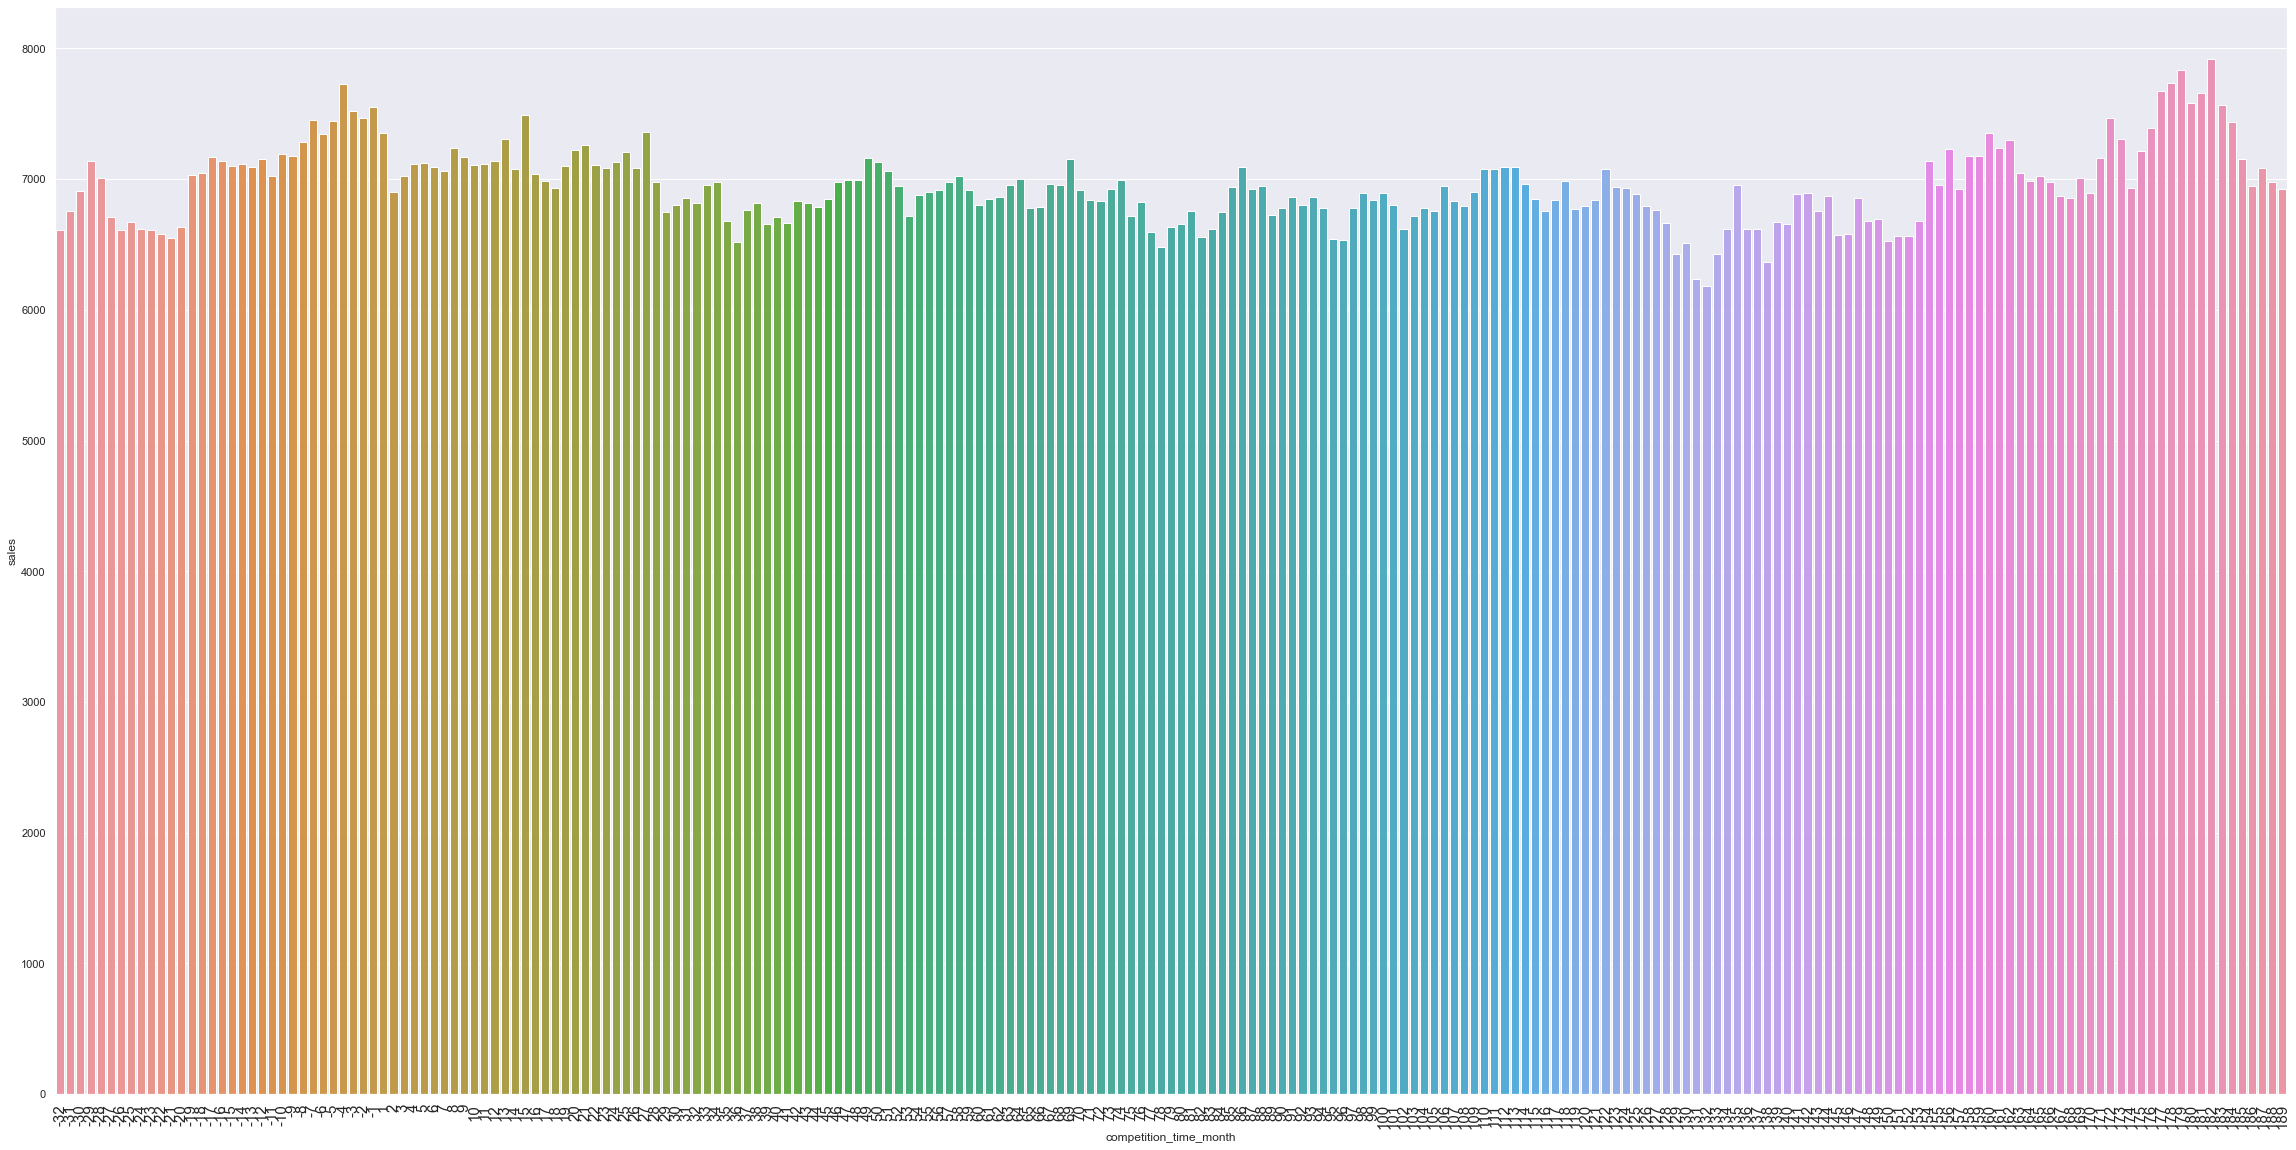

In [378]:
# Para melhorar a visualização acima, iremos limitar a exibição dos competidores que estão
# abertos no máximo 190 meses e não iremos exibir os competidores que possuem valor de 
# competition_time_month igual à zero.
aux16 = aux15[(aux15['competition_time_month'] < 190 ) & (aux15['competition_time_month'] != 0)]
plt.figure(figsize=(40,20))  # Define o tamanho do gráfico.
sns.barplot(x='competition_time_month', y='sales', data=aux16);
plt.xticks(rotation=90, fontsize=15);  # Rotaciona o label da coluna x em 90 graus e especifica o tamanho da fonte do label.

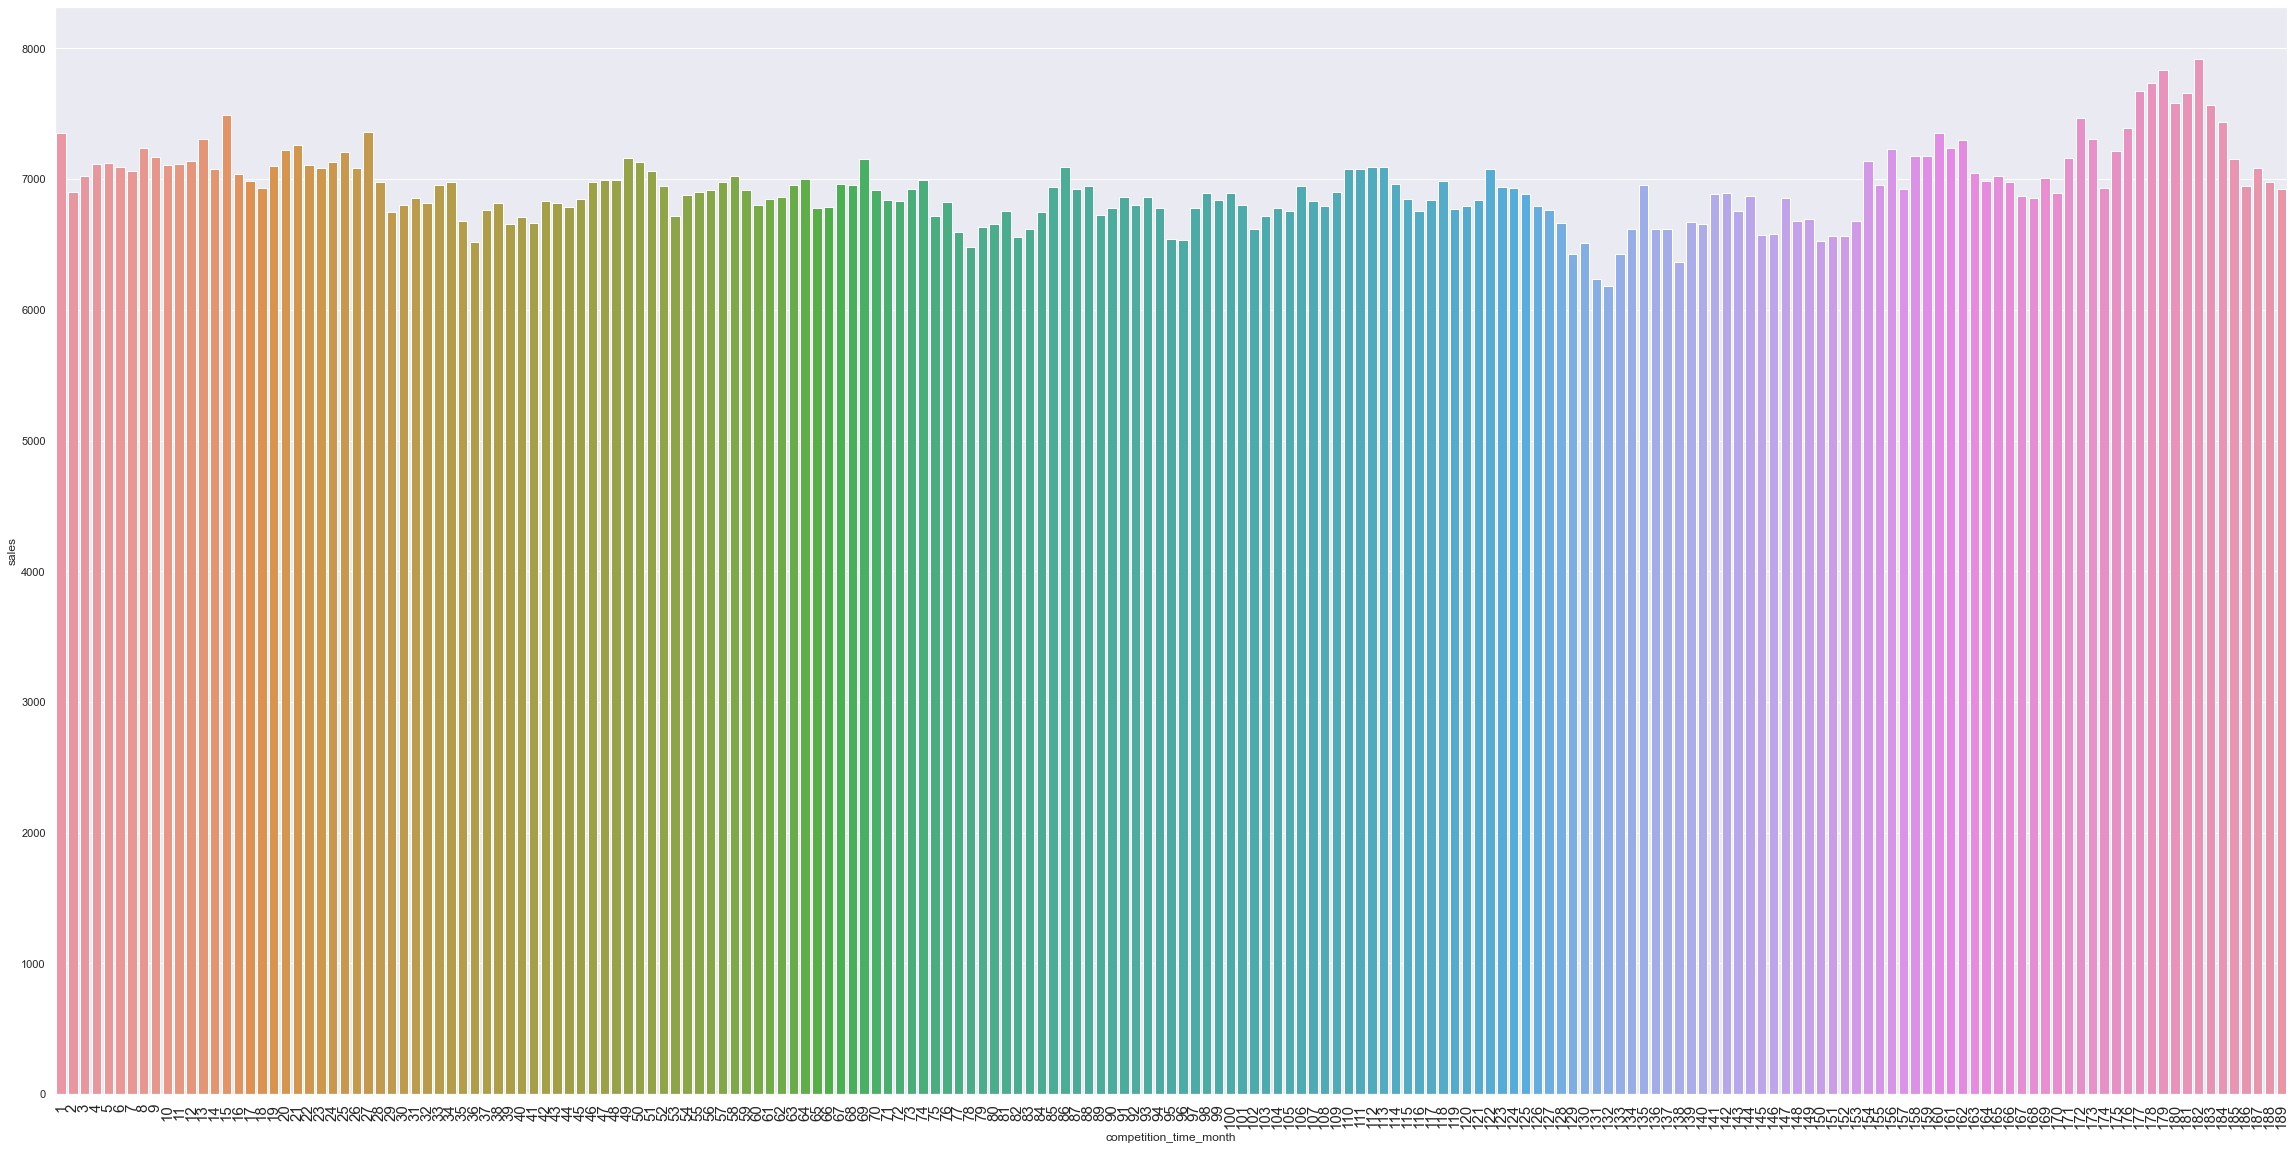

In [379]:
# No gráfico acima, a variável competition_time_month é a diferença de meses da data da venda com a data que o 
# competidor abril. Se estamos vendendo hoje e eu sei que o competidor vai abrir daqui a 4 meses, teremos um
# valor negativo de -4.

# Para não exibir os competidores que ainda irão abrir, iremos limitar a exibição dos competidores que estão
# abertos no máximo 190 meses e não iremos exibir os competidores que abriram em menos de 0 mês.
aux18 = aux15[(aux15['competition_time_month'] < 190 ) & (aux15['competition_time_month'] > 0)]
plt.figure(figsize=(40,20))  # Define o tamanho do gráfico.
sns.barplot(x='competition_time_month', y='sales', data=aux18);
plt.xticks(rotation=90, fontsize=15);  # Rotaciona o label da coluna x em 90 graus e especifica o tamanho da fonte do label.

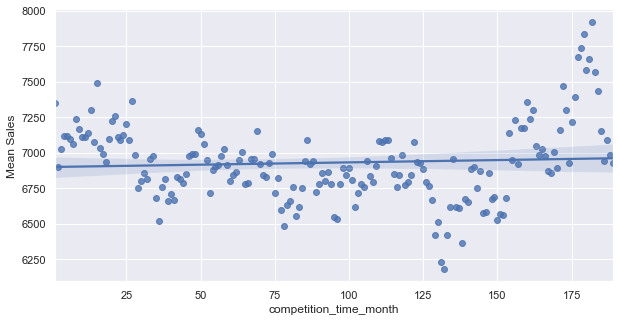

In [380]:
# O gráfico abaixo exibe os dados e a tendência de regressão linear para os dados filtrados,
# sendo, competidores que estão abertos no máximo 190 meses e não exibir os competidores que
# abriram em menos de 0 mês.
sns.regplot(x='competition_time_month', y='sales', data=aux18);
plt.ylabel('Mean Sales');  # Configura o texto da coluna Y.

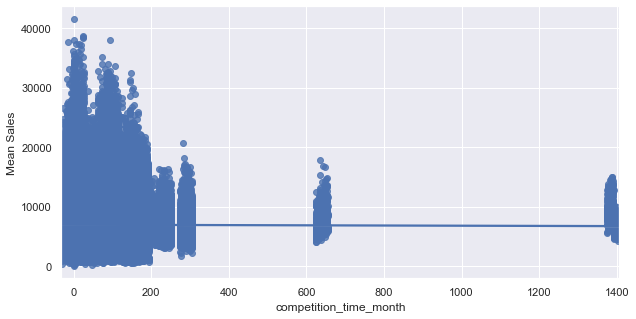

In [381]:
# O gráfico abaixo exibe os dados e a tendência de regressão linear para todos os dados.
sns.regplot(x='competition_time_month', y='sales', data=df4);
plt.ylabel('Mean Sales');  # Configura o texto da coluna Y.

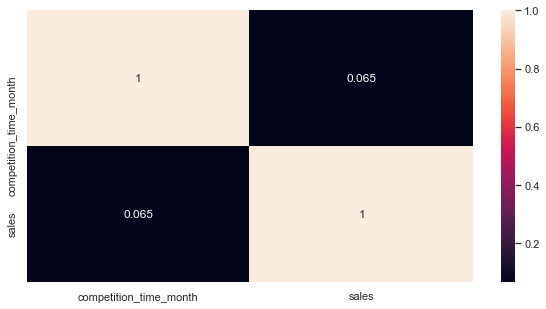

In [382]:
# O gráfico abaixo mede a força da correlação entre as variáveis competition_distance e sales,
# para os dados filtrados, sendo, competidores que estão abertos no máximo 190 meses e não
# exibir os competidores que abriram em menos de 1 mês.
sns.heatmap(aux18.corr(method='pearson'), annot=True);
# Os valores da correlação variam de 1 até -1.  Quanto mais próxima de zero, mais fraca é a 
# correlação. Quanto mais próximo de 1 ou -1, mais forte é a correlação.

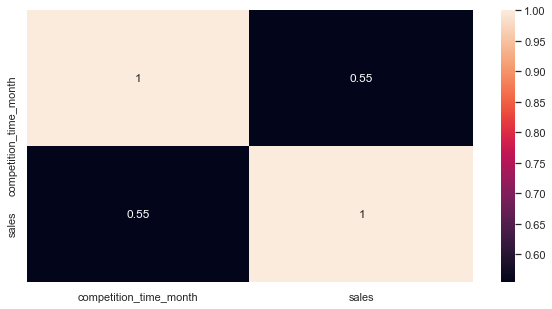

In [383]:
# O gráfico abaixo mede a força da correlação entre as variáveis competition_distance e sales,
# para todos os dados.
sns.heatmap(aux15.corr(method='pearson'), annot=True);
# Os valores da correlação variam de 1 até -1.  Quanto mais próxima de zero, mais fraca é a 
# correlação. Quanto mais próximo de 1 ou -1, mais forte é a correlação.

### **H4.** Lojas com promoções ativas por mais tempo deveriam vender mais.
**FALSA** Lojas com promoções ativas por mais tempo vendem MENOS depois de um certo período de promoção.

In [384]:
# Na fase de Feature Enginnering criamos uma coluna chamada "promo_time_week" contendo o valor em semanas de quanto tempo existe uma promoção.
# Este valor é a diferença da data da coluna "date" com o valor da data da coluna "promo_since", dividindo o resultado por 7 para
# obtermos a quantidade de semanas

# Se o valor da variável promo_time_week pode ter dois valores: positivos ou negativos.

# Se o valor da variável promo_time_week for negativo, significa que a data da venda é menor que a data do início da promoção estendida.
# Isto é, a promoção estendida não começou, significando que a venda foi feita em um periodo tradicional de promoção.

# Se o valor da variável promo_time_week for positivo, significa que a data da venda é maior que a data do início da promoção estendida. 
# Isto é, a promoção estendida já começou, significando que a venda foi feita em um período de promoção estendida.

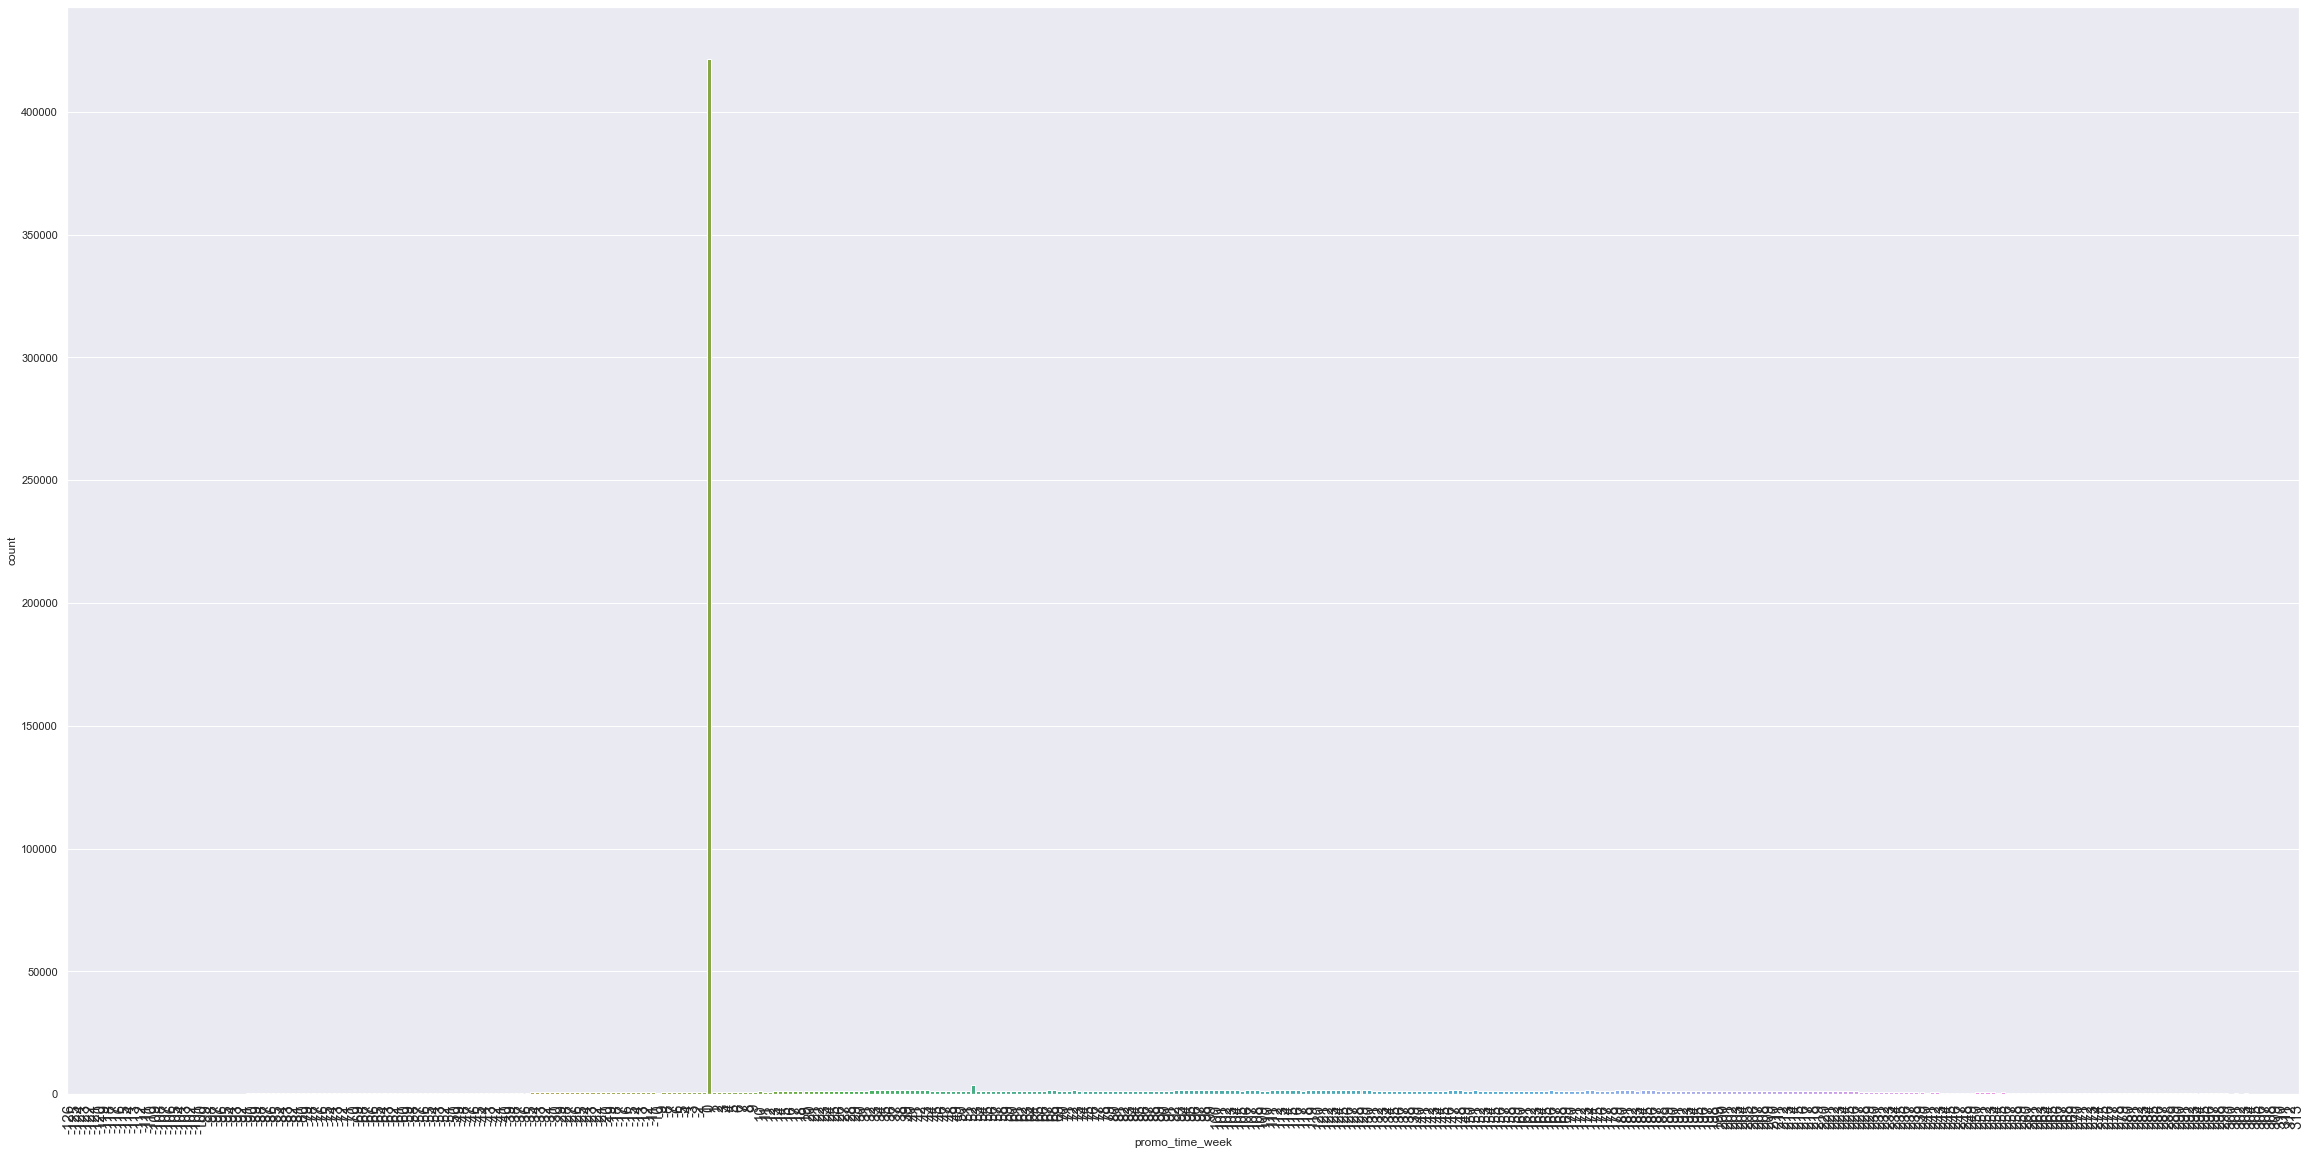

In [385]:
# Gráfico para exibir a quantidade de ocorrências para cada valor de promo_time_week.
plt.figure(figsize=(40,20))  # Define o tamanho do gráfico.
sns.countplot(x=df4['promo_time_week'])
plt.xticks(rotation=90, fontsize=15);  # Rotaciona o label da coluna x em 90 graus e especifica o tamanho da fonte do label.

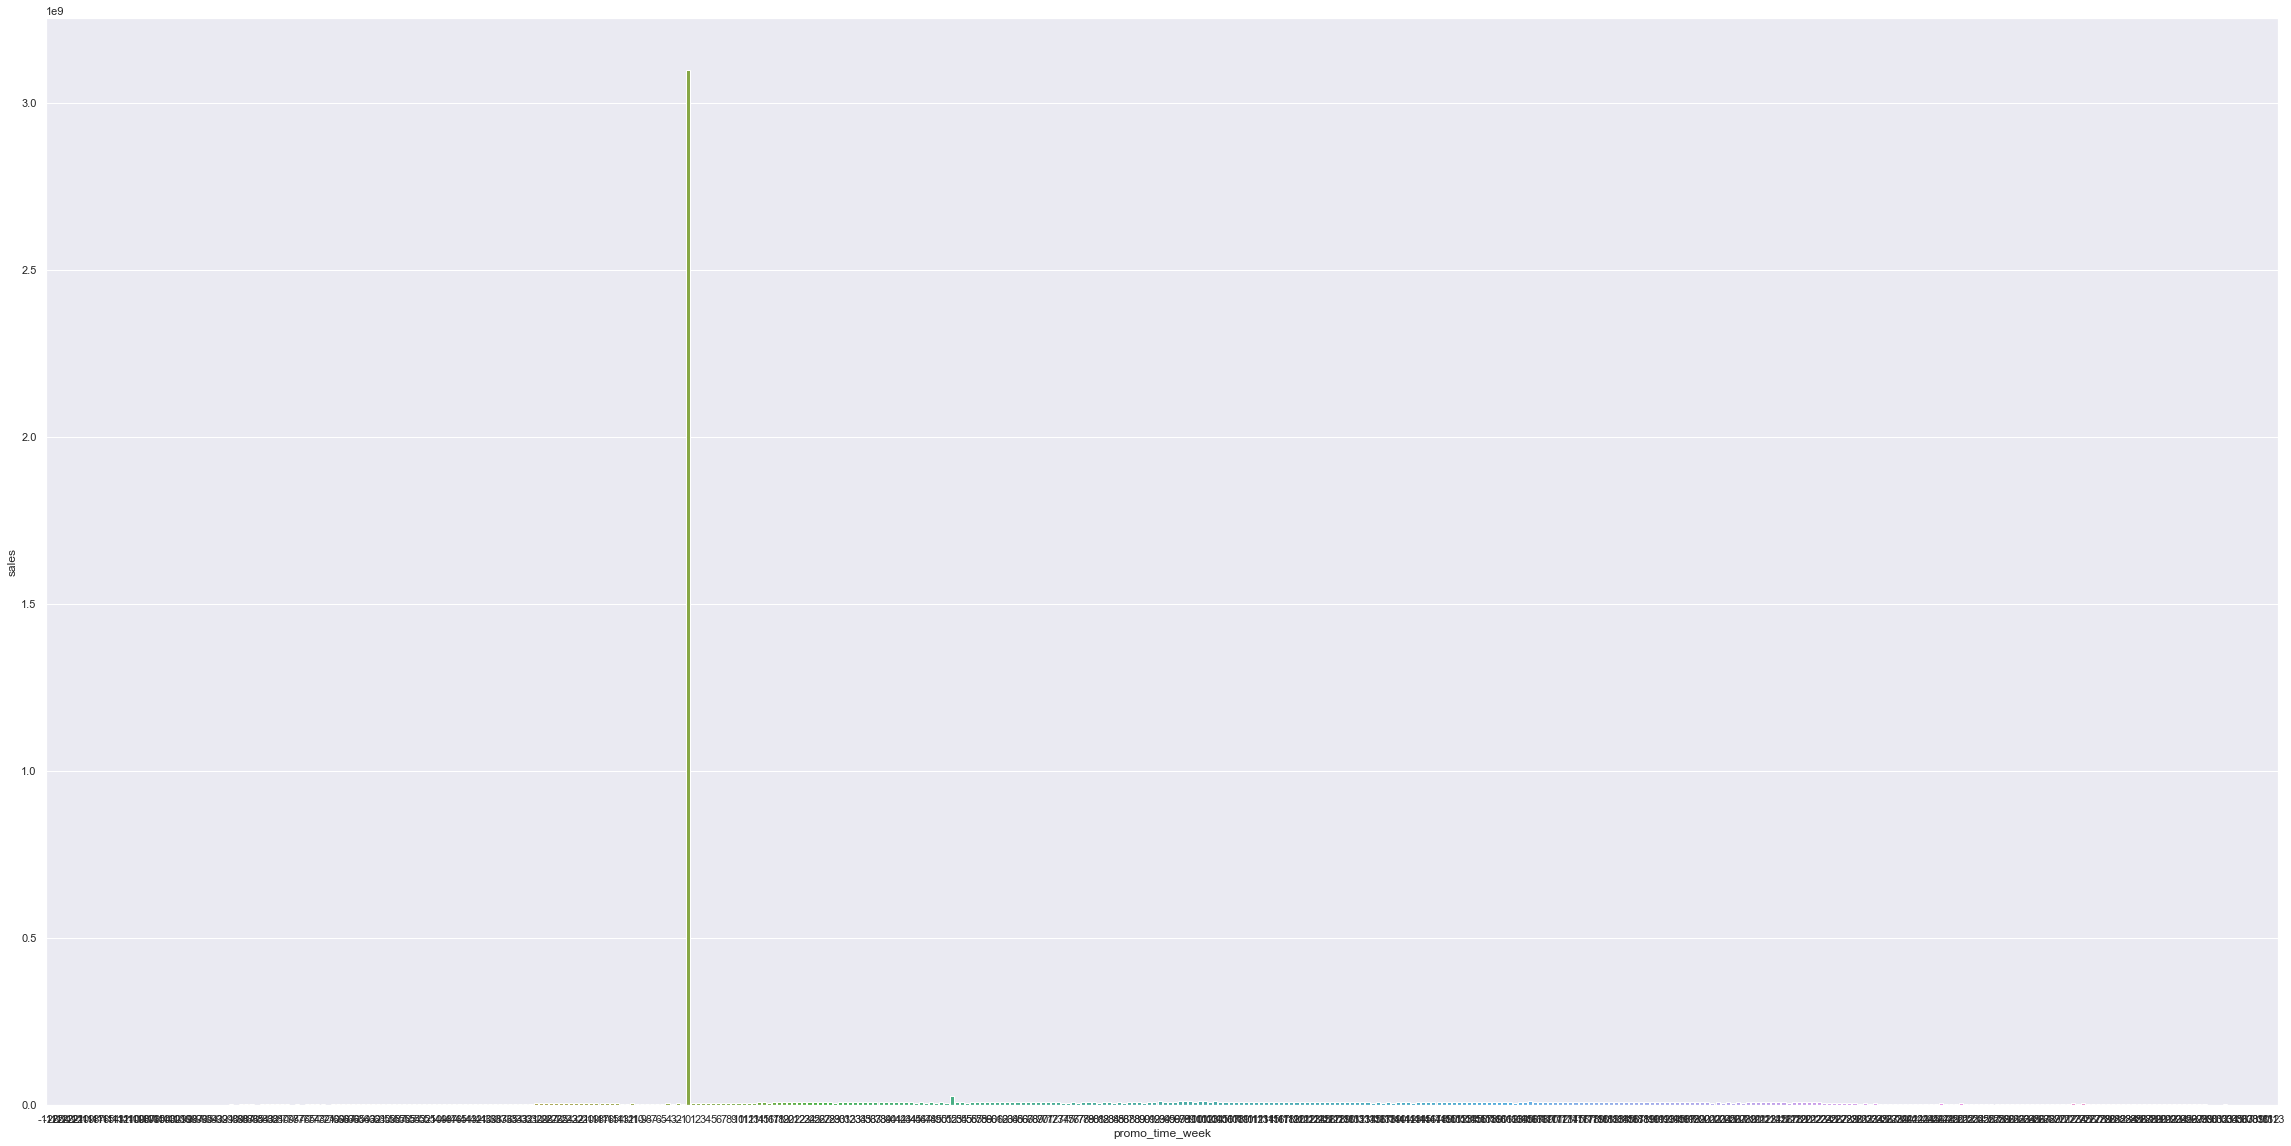

In [386]:
# O comando abaixo armazena a soma das vendas agrupados para cada valor de promo_time_week.
aux20 = df4[['promo_time_week', 'sales']].groupby('promo_time_week').sum().reset_index()

# Exibe um gráfico de barras.
plt.figure(figsize=(40,20))  # Define o tamanho do gráfico.
sns.barplot(x='promo_time_week', y= 'sales', data=aux20);

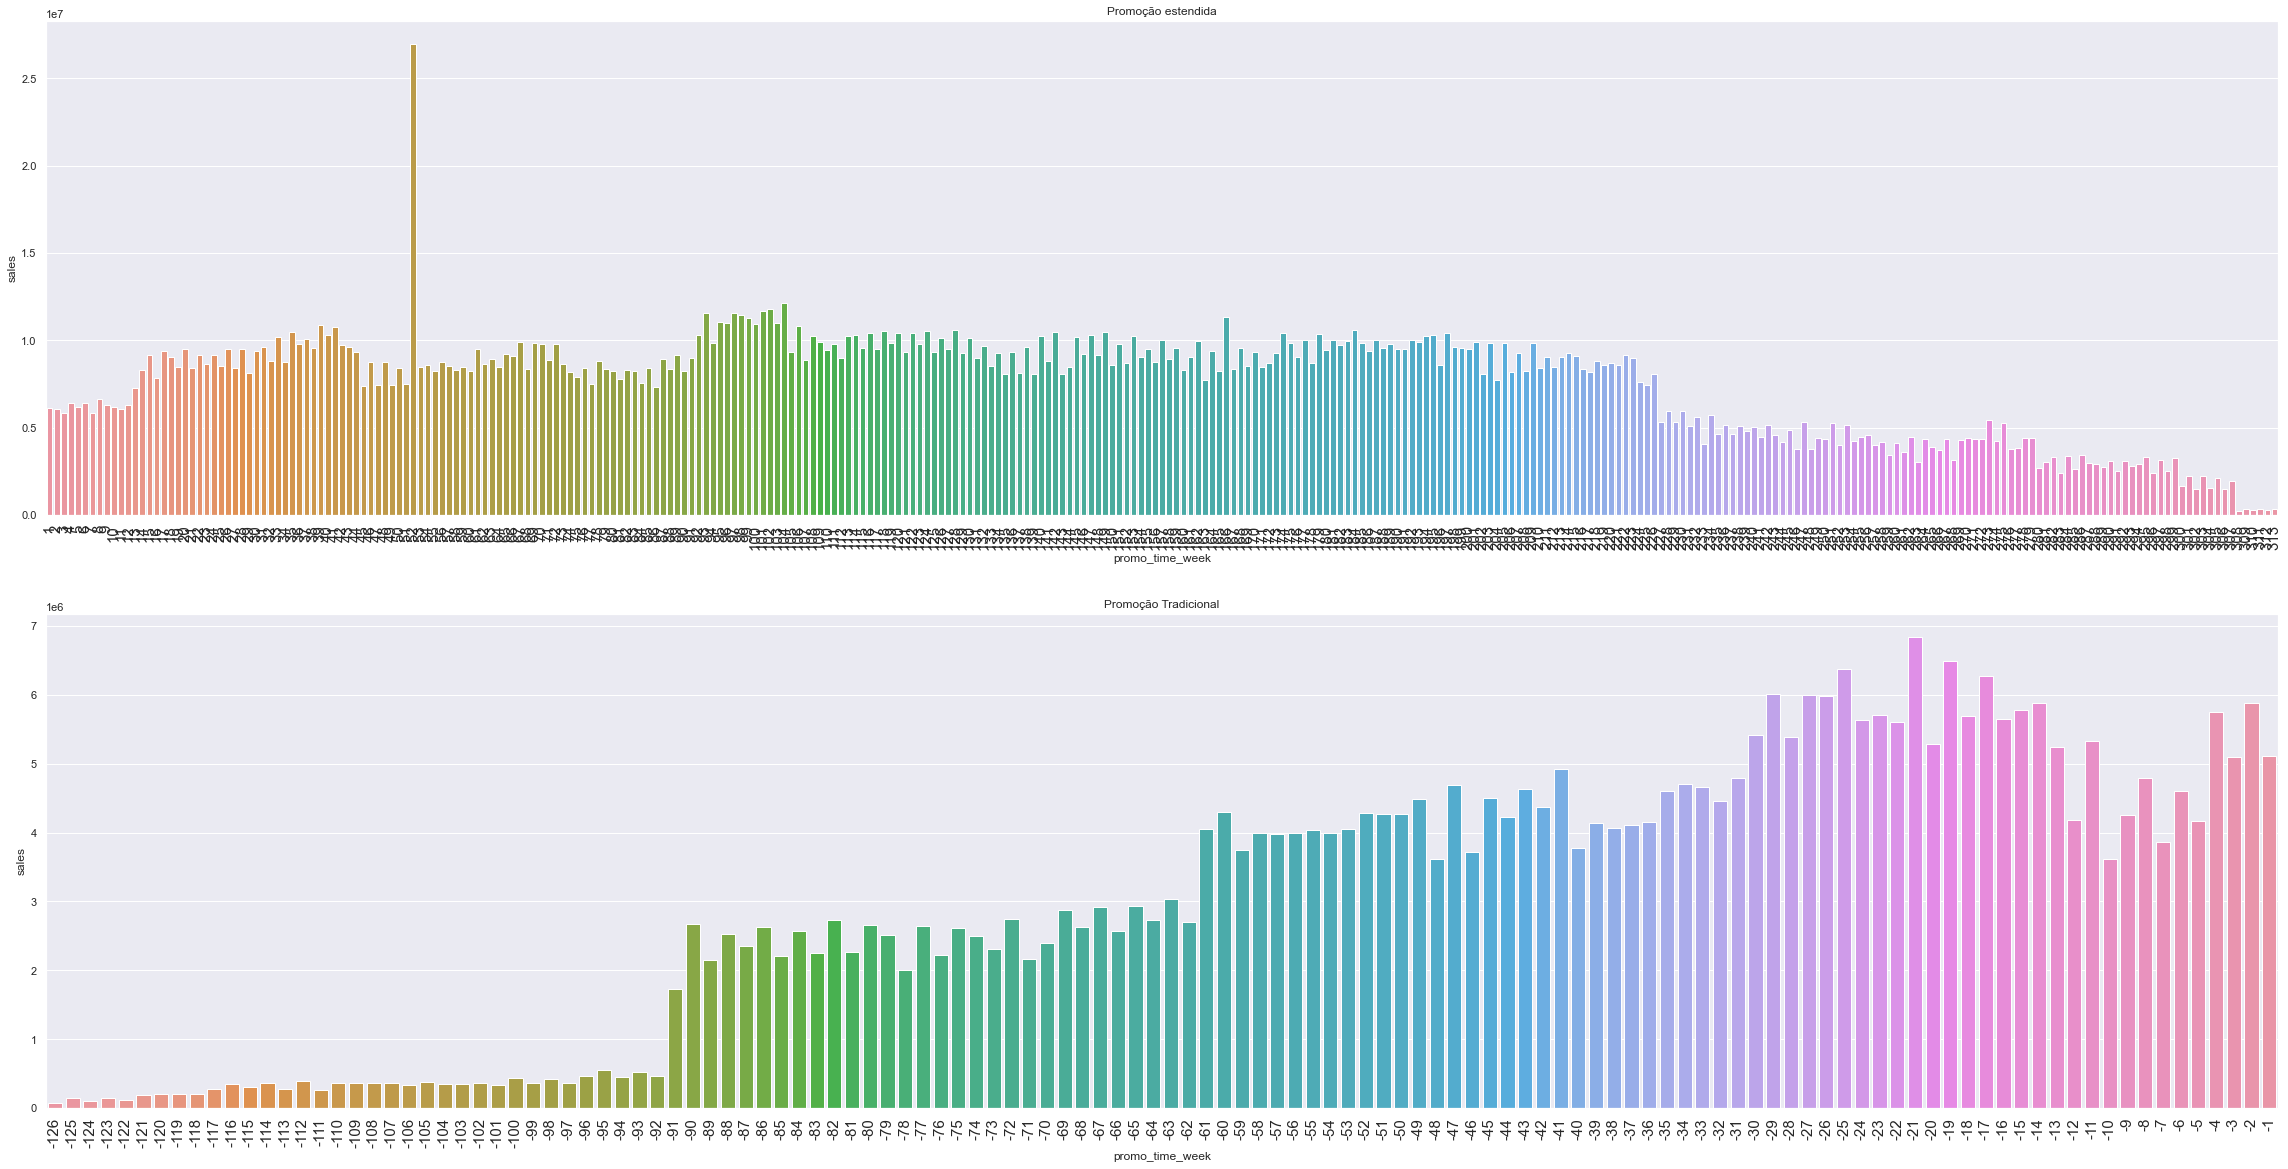

In [387]:
# Para melhorar a visualização separamos a visualização para cada período de promoção tradicional e estendido.

# O comando abaixo armazena a soma das vendas agrupados para cada valor de promo_time_week.
aux20 = df4[['promo_time_week', 'sales']].groupby('promo_time_week').sum().reset_index()

plt.figure(figsize=(40,20))  # Define o tamanho do gráfico.

plt.subplot(2,1,1)
aux21 = aux20[aux20['promo_time_week'] > 0]  # Promoção estendida.
sns.barplot(x='promo_time_week', y= 'sales', data=aux21).set_title('Promoção estendida');
plt.xticks(rotation=90, fontsize=15);  # Rotaciona o label da coluna x em 90 graus e especifica o tamanho da fonte do label.

plt.subplot(2,1,2)
aux22 = aux20[aux20['promo_time_week'] < 0]  # Promoção tradicional.
sns.barplot(x='promo_time_week', y= 'sales', data=aux22).set_title('Promoção Tradicional');
plt.xticks(rotation=90, fontsize=15);  # Rotaciona o label da coluna x em 90 graus e especifica o tamanho da fonte do label.

In [388]:
# No gráfico de promoção estendida acima, podemos observar que temos um patamar de vendas que se mantém ate uma certa semana,
# e depois começa a cair. O Insight é que a promoção estendida tem um tempo determinado que o efeito dela funciona. 
# após este período temos uma queda nas vendas.
# Podemos concluir que a hipótese é falsa pois as lojas vendem mais regularmente até um certo tempo e depois as vendam diminuem.

# No gráfico de promoção tradicional observamos que quando estamos chegando próximo da data da promoção estendida, 
# existem saltos nas vendas, nas semanas -90, -60 e -30. Isto pode ser um efeito de campanhas de marketing avisando
# que vai ocorrer uma promoção. As pessoas começam a perceber que irão ter oportunidade melhor de compra com desconto e elas
# começam a aumentar a compra.

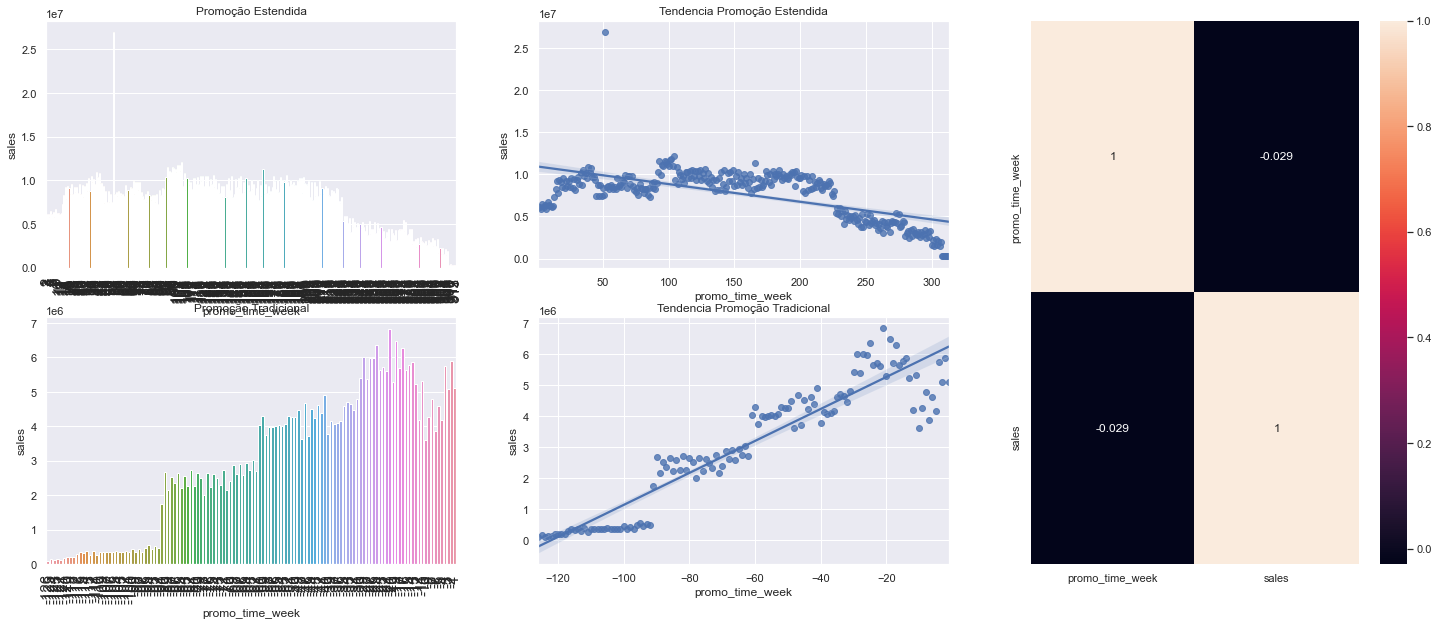

In [389]:
# Exibe os gráficos de barras para volume de vendas por tipo de promoção, o gráfico de tendencias e o gráfico da força da correlação.

# O comando abaixo armazena a soma das vendas agrupados para cada valor de promo_time_week.
aux20 = df4[['promo_time_week', 'sales']].groupby('promo_time_week').sum().reset_index()

fig = plt.figure( figsize=(25,10))
grid = gridspec.GridSpec(ncols=3, nrows=2, figure=fig)

plt.subplot(grid[0,0])
aux21 = aux20[aux20['promo_time_week'] > 0]  # Promoção estendida.
sns.barplot(x='promo_time_week', y= 'sales', data=aux21).set_title('Promoção Estendida');
plt.xticks(rotation=90, fontsize=15);  # Rotaciona o label da coluna x em 90 graus e especifica o tamanho da fonte do label.

plt.subplot(grid[0,1])
sns.regplot(x='promo_time_week', y='sales', data=aux21).set_title('Tendencia Promoção Estendida');

plt.subplot(grid[1,0])
aux22 = aux20[aux20['promo_time_week'] < 0]  # Promoção tradicional.
sns.barplot(x='promo_time_week', y= 'sales', data=aux22).set_title('Promoção Tradicional');
plt.xticks(rotation=90, fontsize=15);  # Rotaciona o label da coluna x em 90 graus e especifica o tamanho da fonte do label.

plt.subplot(grid[1,1])
sns.regplot(x='promo_time_week', y='sales', data=aux22).set_title('Tendencia Promoção Tradicional');

plt.subplot(grid[2:])  # Ocupa as duas últimas linhas da terceira coluna.
sns.heatmap(aux20.corr(method='pearson'), annot=True);

### <s>**H5.** Lojas com mais dias de promoção deveriam vender mais.</s>

In [390]:
# A Hipótese 4: "Lojas com promoções ativas por mais tempo deveriam vender mais" é bem similar
# à hipótese 5: "Lojas com mais dias de promoção deveriam vender mais".
# Para podermos validar esta hipótese 5, temos que criar uma nova variável chamada dias_de_promocao,
# e agrupar os dias_de_promocao por loja. Como estamos trabalhando com o CRISP, iremos validar esta hipótese
# no segundo ciclo do CRISP.

### **H6.** Lojas com mais promoções consecutivas deveriam vender mais.
**FALSA** Lojas com mais promoções consecutivas vendem MENOS.

In [391]:
# Valida se as lojas que entram no período consecutivo de promoção vendem mais que as lojas
# que não entram no período consecutivo de promoção.

In [392]:
# Exibe a quantidade de lojas que não participaram de nenhuma promoção.
df4[(df4['promo'] == 0) & (df4['promo2'] == 0)].shape[0]

234287

In [393]:
# Exibe a quantidade de lojas que participaram da promoção estendida.
df4[(df4['promo'] == 0) & (df4['promo2'] == 1)].shape[0]

233176

In [394]:
# Exibe a quantidade de lojas que participaram da promoção tradicional.
df4[(df4['promo'] == 1) & (df4['promo2'] == 0)].shape[0]

189005

In [395]:
# Exibe a quantidade de lojas que participaram de ambas as promoções, isto é, do período consecutivo de promoção.
df4[(df4['promo'] == 1) & (df4['promo2'] == 1)].shape[0]

187870

In [396]:
# Exibe a soma das vendas agrupados pelos atributos promo e promo2.
df4[['promo', 'promo2', 'sales']].groupby(['promo', 'promo2']).sum().reset_index()

,promo,promo2,sales
0,0,0,1482612096
1,0,1,1289362241
2,1,0,1628930532
3,1,1,1472275754


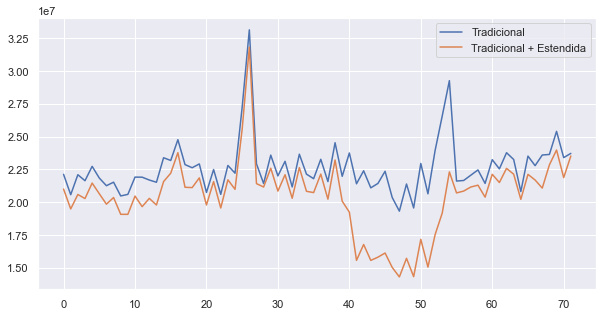

In [397]:
# Exibe um gráfico da quantidade de vendas ao longo do tempo, considerando as lojas que participaram da promoção
# tradicional e das lojas que participaram da promoção consecutiva, isto é, tradicional+estendida.

# Exibe o gráfico da soma das vendas ao longo do tempo para as lojas que participaram apenas da promoção tradicional.
aux23 = df4[(df4['promo'] == 1) & (df4['promo2'] == 0)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
ax = aux23.plot()

# Exibe o gráfico da soma das vendas ao longo do tempo para as lojas que participaram da promoção consecutiva,
# isto é, que participaram da promoção tradicional e estendida.
aux24= df4[(df4['promo'] == 1) & (df4['promo2'] == 1)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
aux24.plot(ax=ax)  # ax=ax significa para plotar o gráfico no mesmo gráfico ax anterior.

ax.legend(labels=['Tradicional', 'Tradicional + Estendida'])

In [398]:
# No gráfico acima observamos que as lojas que participaram da promoção consecutiva,
# isto é, (tradicional + estendida) possuem um volume de vendas menor do que as lojas
# que apenas participaram da promoção tradicional.

### **H7.** Lojas abertas durante o feriado de Natal deveriam vender mais.
**FALSA** Lojas abertas durante o Natal vendem menos do que as lojas abertas durante o feriado de páscoa.

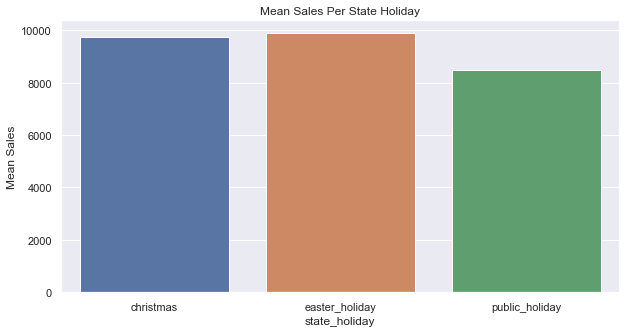

In [399]:
# Exibe a média das vendas para cada tipo de feriado (state_holiday), excluíndo os dias normais.
aux25 = df4[df4['state_holiday'] != 'regular_day']
aux26 = aux25[['state_holiday', 'sales']].groupby('state_holiday').mean().reset_index()
sns.barplot(x='state_holiday', y='sales', data=aux26).set_title('Mean Sales Per State Holiday');
plt.ylabel('Mean Sales');  # Configura o texto da coluna Y.

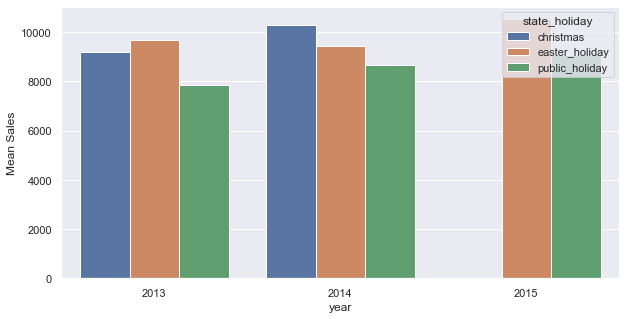

In [400]:
# O exemplo abaixo verifica o comportamento das vendas dos feriados ao longo dos anos.
aux27 = aux25[['year', 'state_holiday', 'sales']].groupby(['year', 'state_holiday']).mean().reset_index()
sns.set(rc={"figure.figsize":(10, 5)}) #width=10, height=5
sns.barplot(x='year', y='sales', hue='state_holiday', data=aux27);
plt.ylabel('Mean Sales');  # Configura o texto da coluna Y.
# O gráfico abaixo informa que o feriado de natal vendeu mais na média no ano de
# 2014 do que no ano de 2013. O gráfico mostra também que o ano de 2015 ainda não está 
# completo, pois não existe o feriado de natal em 2015.

### **H8.** Lojas deveriam vender mais ao longo dos anos.
**VERDADEIRA** Lojas vendem MAIS ao longo dos anos.

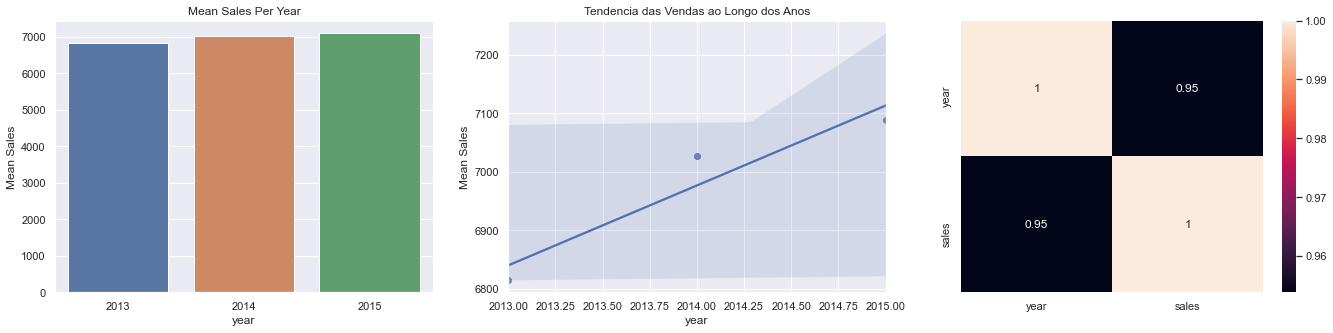

In [401]:
# Exibe a média das vendas ao longo dos anos, o gráfico de tendencias e o gráfico da força da correlação.
aux28 = df4[['year', 'sales']].groupby('year').mean().reset_index()

plt.figure(figsize=(23,5))

plt.subplot(1, 3, 1) # Uma linha e três colunas na primeira posição.
sns.barplot(x='year', y='sales', data=aux28).set_title('Mean Sales Per Year');
plt.ylabel('Mean Sales');  # Configura o texto da coluna Y.

plt.subplot(1, 3, 2) # Uma linha e três colunas na segunda posição.
sns.regplot(x='year', y='sales', data=aux28).set_title('Tendencia das Vendas ao Longo dos Anos');
plt.ylabel('Mean Sales');  # Configura o texto da coluna Y.

plt.subplot(1, 3, 3) # Uma linha e três colunas na terceira posição.
sns.heatmap(aux28.corr(method='pearson'), annot=True);

### **H9.** Lojas deveriam vender mais no segundo semestre do ano.
**VERDADEIRA** Lojas vendem MAIS no segundo semestre.

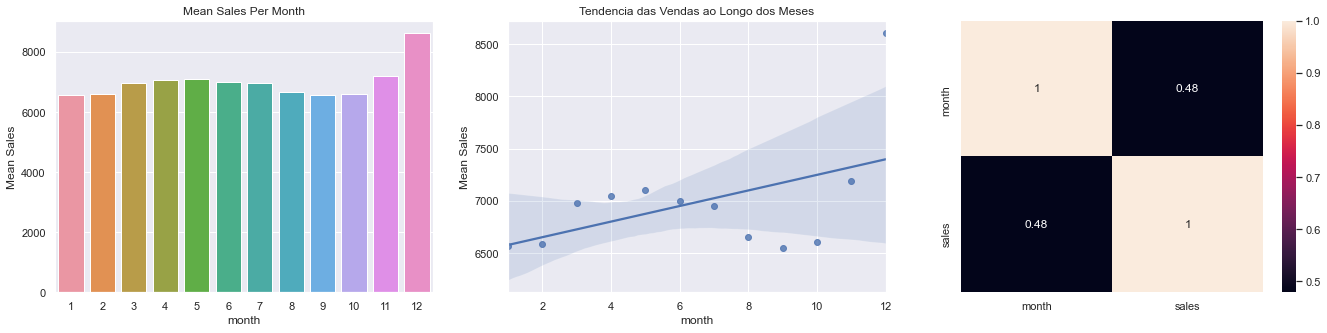

In [402]:
# Exibe a média das vendas ao longo dos meses, o gráfico de tendencias e o gráfico da força da correlação.
aux29 = df4[['month', 'sales']].groupby('month').mean().reset_index()

plt.figure(figsize=(23,5))

plt.subplot(1, 3, 1) # Uma linha e três colunas na primeira posição.
sns.barplot(x='month', y='sales', data=aux29).set_title('Mean Sales Per Month');
plt.ylabel('Mean Sales');  # Configura o texto da coluna Y.

plt.subplot(1, 3, 2) # Uma linha e três colunas na segunda posição.
sns.regplot(x='month', y='sales', data=aux29).set_title('Tendencia das Vendas ao Longo dos Meses');
plt.ylabel('Mean Sales');  # Configura o texto da coluna Y.

plt.subplot(1, 3, 3) # Uma linha e três colunas na terceira posição.
sns.heatmap(aux29.corr(method='pearson'), annot=True);

### **H10.** Lojas deveriam vender mais depois do dia 10 de cada mês.
**FALSA** Lojas vendem MENOS depois do dia 10 de cada mês.

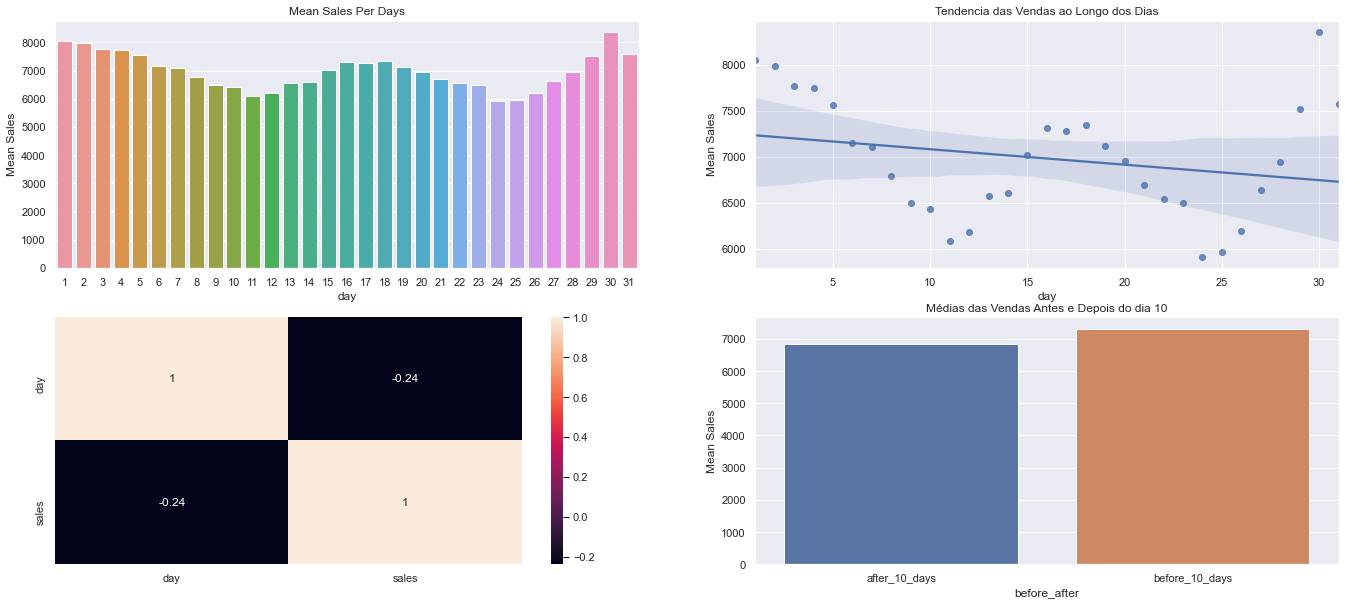

In [403]:
# Exibe a média das vendas ao longo dos dias, o gráfico de tendencias,
# o gráfico da força da correlação e o gráfico da média das vendas antes
# e depois do dia 10.
aux30 = df4[['day', 'sales']].groupby('day').mean().reset_index()

plt.figure(figsize=(23,10))

plt.subplot(2, 2, 1) # Duas linha e duas colunas na primeira posição.
sns.barplot(x='day', y='sales', data=aux30).set_title('Mean Sales Per Days');
plt.ylabel('Mean Sales');  # Configura o texto da coluna Y.

plt.subplot(2, 2, 2) # Duas linha e duas colunas na segunda posição.
sns.regplot(x='day', y='sales', data=aux30).set_title('Tendencia das Vendas ao Longo dos Dias');
plt.ylabel('Mean Sales');  # Configura o texto da coluna Y.

plt.subplot(2, 2, 3) # Duas linha e duas colunas na terceira posição.
sns.heatmap(aux30.corr(method='pearson'), annot=True);

# Cria uma coluna chamada before_after onde armazena o valor before_10_days
# se o dia for menor ou igual à 10 e armazena o valor after_10_days se o dia
# for maior que 10.
aux30['before_after'] = aux30['day'].apply(lambda x: 'before_10_days' if x <= 10 else 'after_10_days')

# Armazena a média das vendas por tipo do atributo before_after. 
aux31 = aux30[['before_after', 'sales']].groupby('before_after').mean().reset_index()

plt.subplot(2, 2, 4) # Duas linha e duas colunas na quarta posição.
sns.barplot(x='before_after', y='sales', data=aux31).set_title('Médias das Vendas Antes e Depois do dia 10');
plt.ylabel('Mean Sales');  # Configura o texto da coluna Y.

In [404]:
aux30.head(31)

,day,sales,before_after
0,1,8054.505835,before_10_days
1,2,7987.998803,before_10_days
2,3,7765.916826,before_10_days
3,4,7746.632622,before_10_days
4,5,7556.054806,before_10_days
5,6,7149.914351,before_10_days
6,7,7101.614663,before_10_days
7,8,6785.606424,before_10_days
8,9,6499.517013,before_10_days
9,10,6429.867986,before_10_days


### **H11.** Lojas deveriam vender menos aos finais de semana.
**FALSA** Lojas vendem MENOS aos Sábados, porém vendem MAIS aos Domingos.

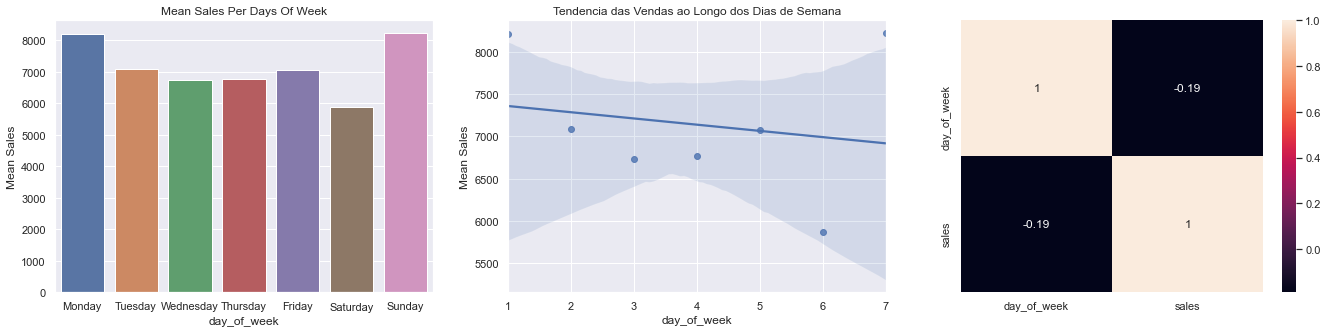

In [433]:
# Exibe a média das vendas ao longo dos dias da semana, o gráfico de tendencias e o gráfico da força da correlação.
aux32 = df4[['day_of_week', 'sales']].groupby('day_of_week').mean().reset_index()

aux33 = aux32.copy()

# Altera os valores do atributo day_of_week para o nome dos dias da semana.
aux33['day_of_week'] = aux33['day_of_week'].apply(lambda x: 'Monday' if x == 1 else 'Tuesday' if x == 2 else 'Wednesday' if x == 3 else 'Thursday' if x == 4 else 'Friday' if x == 5 else 'Saturday' if x == 6 else 'Sunday')

plt.figure(figsize=(23,5))

plt.subplot(1, 3, 1) # Uma linha e três colunas na primeira posição.
sns.barplot(x='day_of_week', y='sales', data=aux33).set_title('Mean Sales Per Days Of Week');
plt.ylabel('Mean Sales');  # Configura o texto da coluna Y.

plt.subplot(1, 3, 2) # Uma linha e três colunas na segunda posição.
sns.regplot(x='day_of_week', y='sales', data=aux32).set_title('Tendencia das Vendas ao Longo dos Dias de Semana');
plt.ylabel('Mean Sales');  # Configura o texto da coluna Y.

plt.subplot(1, 3, 3) # Uma linha e três colunas na terceira posição.
sns.heatmap(aux32.corr(method='pearson'), annot=True);

In [407]:
# No gráfico acima, a segunda-feira é representado pelo valor 1 no atributo day_of_week.
# Portanto, os finais de semana são representados pelos valores 6 e 7.
# Nos gráficos acima, a média das vendas aos Sábados é baixa, porém a média das vendas
# aos Domingos é alta.

### **H12.** Lojas deveriam vender menos durante os feriados escolares.
**FALSA** Lojas vendem MAIS durante os feriados escolares.

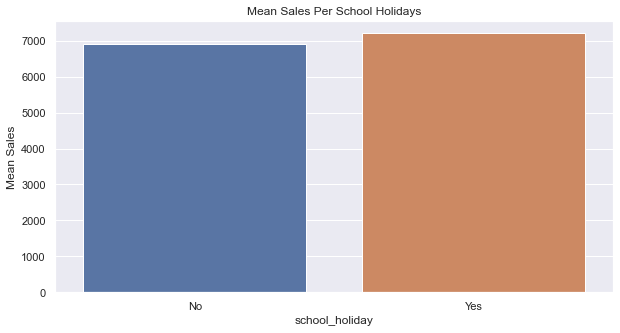

In [434]:
# Armazena a média das vendas por tipo de feriado escolar.
aux34 = df4[['school_holiday', 'sales']].groupby('school_holiday').mean().reset_index()

# Altera os valores do atributo school_holiday para o Yes ou No.
aux34['school_holiday'] = aux34['school_holiday'].apply(lambda x: 'No' if x == 0 else 'Yes')

sns.barplot(x='school_holiday', y='sales', data=aux34).set_title('Mean Sales Per School Holidays');
plt.ylabel('Mean Sales');  # Configura o texto da coluna Y.

In [440]:
# O gráfico acima mostra que a média das vendas durante os feriados escolares é um
# pouco superior que os dias que não são feriados escolares.

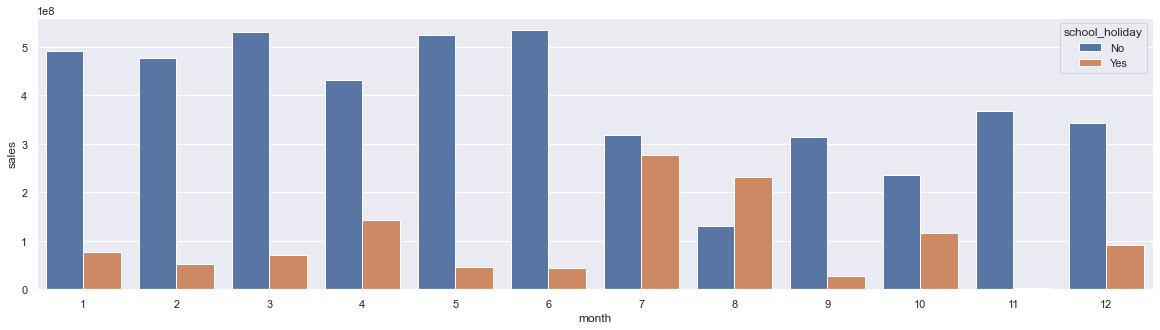

In [439]:
# O gráfico abaixo exibe a soma das vendas para os dias que são feriados escolares
# e para os dias que não são feriados escolares ao longo do ano.
# Podemos notar que os meses 7 e 8 férias devido ao aumento no volume de vendas
# nos dias que são feriados escolares.

# Armazena a soma das vendas por mês e por tipo de feriado escolar.
aux35 = df4[['month', 'school_holiday', 'sales']].groupby(['month', 'school_holiday']).sum().reset_index()

# Altera os valores do atributo school_holiday para o Yes ou No.
aux35['school_holiday'] = aux35['school_holiday'].apply(lambda x: 'No' if x == 0 else 'Yes')

plt.figure(figsize=(20,5))

sns.barplot(x='month', y='sales', hue='school_holiday', data=aux35);

## 4.3. Análise Multivariada